# Analysis

This notebook includes code for analyzing and plotting processed library activity measurements.

In [1]:
import os

os.environ["POLARS_MAX_THREADS"] = os.environ["SLURM_CPUS_PER_TASK"]
print(f"{os.environ['SLURM_CPUS_PER_TASK']} thread(s) available")

FIGURE_EXPORT_TYPE = "svg"

8 thread(s) available


In [2]:
from IPython.display import display, Markdown, HTML

%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("jpeg")

import matplotlib
import matplotlib.pyplot as pyplot
import seaborn
from matplotlib_venn import venn2

import numpy
import polars
import pandas
import scipy
import statsmodels.api as statsmods

import json

polars.enable_string_cache()
_ = polars.Config.set_tbl_rows(10)

In [3]:
"""
Style Matplotlib plots
"""

plot_style = {
    "font.size": 12,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter"],
    "figure.figsize": [2, 2],
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.facecolor": (1, 1, 1, 0),
    "text.usetex": False,
    "lines.markersize": 3,
    "axes.titleweight": "bold",
    "axes.labelweight": 600,
    "axes.labelsize": 9,
    "axes.facecolor": "none",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.5,
    "grid.color": "#303030",
    "grid.alpha": 0.1,
    "xtick.labelsize": 9,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1,
    "xtick.minor.visible": False,
    "ytick.labelsize": 9,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1,
    "ytick.minor.visible": False,
    "figure.frameon": False,
    "legend.frameon": False,
    "legend.fancybox": False,
    "legend.fontsize": 9,
    "legend.scatterpoints": 1,
    "legend.markerscale": 1,
    "legend.handlelength": 1.0,
    "legend.handletextpad": 0.2,
    "axes.prop_cycle": matplotlib.cycler(color=["k", "b", "g", "r", "c", "y"]),
    "hatch.linewidth": 4,
}

pyplot.style.use(plot_style)
_ = pyplot.ioff()

cm_white_to_gray = matplotlib.colors.LinearSegmentedColormap.from_list("white_to_gray", ["#ffffff", "#404040"])
cm_white_to_red = matplotlib.colors.LinearSegmentedColormap.from_list("white_to_red", ["#ffffff", "#ff0000"])
cm_white_to_blue = matplotlib.colors.LinearSegmentedColormap.from_list("white_to_blue", ["#ffffff", "#0000ff"])
cm_white_to_green = matplotlib.colors.LinearSegmentedColormap.from_list("white_to_green", ["#ffffff", "#009000"])

cm_light_to_gray = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_gray", ["#e0e0e0", "#404040"])
cm_light_to_red = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_red", ["#ffe0e0", "#ff0000"])
cm_light_to_blue = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_blue", ["#e0e0ff", "#0000ff"])
cm_light_to_green = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_green", ["#e0ffe0", "#009000"])

boxplot_style_args = {
    "whiskerprops": {
        "color": "#000000"
    },
    "boxprops": {
        "edgecolor": "#000000",
    },
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "#000000",
        "markersize": 1,
        "markeredgecolor": None
    },
    "medianprops": {
        "color": "#000000"
    },
    "capprops": {
        "color": "#000000"
    }
}

In [4]:
"""
Common plotting functions
"""

# Adapted from https://stackoverflow.com/a/53865762

def calc_weights_for_scatter(x, y, bins=20):
    if type(x) is not numpy.ndarray or type(y) is not numpy.ndarray:
        raise ValueError("x and y must be `numpy.ndarray`s")
    
    bin_weights, xbins, ybins = numpy.histogram2d(x, y, bins=bins, density=False)
    weights = scipy.interpolate.interpn(points=(0.5*(xbins[1:] + xbins[:-1]), 0.5*(ybins[1:] + ybins[:-1])), values=bin_weights, xi=numpy.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    weights[numpy.where(numpy.isnan(weights))] = 0.0
    
    normalizer = matplotlib.colors.Normalize(vmin=numpy.min(weights), vmax=numpy.max(weights))
    
    return weights, normalizer

def reorder_points_and_weights(x, y, w, f = None):
    if type(x) is not numpy.ndarray or type(y) is not numpy.ndarray or type(w) is not numpy.ndarray:
        raise ValueError("x, y, and w must be `numpy.ndarray`s")
    
    x_, y_, w_ = x, y, w
    if f is not None:
        x_, y_, w_ = f(x), f(y), f(w)
    order = numpy.argsort(w_)
    return {
        "x": x_[order],
        "y": y_[order],
        "c": w_[order]
    }

NAME_TRANSLATION_TABLE = {
    "WT": "+/+",
    "Rhet": "R90W/+",
    "Rhom": "R90W/R90W",
    "Ehet": "E168d2/+",
    "Ehom": "E168d2/E168d2",
    "CrxKO": "-/-",
    "chip_peak_id": "CRE"
}

def translate_genotype_to_label(genotype):
    return NAME_TRANSLATION_TABLE[genotype]

In [5]:
"""
Load library metadata
"""

library_metadata = polars.read_csv("Library_Details/library_metadata.tsv", separator="\t", dtypes={
    "variant_type": polars.Categorical
})

chip_peak_metadata = polars.read_csv("Library_Details/chip_peak_metadata.tsv", separator="\t", dtypes={
    "atac_crx_dependent": polars.Categorical,
    "epigenome_group": polars.Categorical
})

display(Markdown("### Library Metadata"))
display(library_metadata)

display(Markdown("### ChIP Peak Metadata"))
display(chip_peak_metadata)

### Library Metadata

library_id,variant_type,chip_peak_id,CRE_sequence
str,cat,str,str
"""basal""","""basal""",null,"""ACTAGTTCAATCAA…"
"""Scramble.1""","""scrambled""",null,"""CGCCCCTCCCCCAG…"
"""Scramble.2""","""scrambled""",null,"""AACCTGGCAAGAAG…"
"""Scramble.3""","""scrambled""",null,"""GCTTCTGAAAGGGC…"
"""Scramble.4""","""scrambled""",null,"""GGGGGGGGGGGGGA…"
…,…,…,…
"""CRX.6340_full_…","""allCrxSites""","""CRX.6340""","""ACGAGGACTGAGAA…"
"""CRX.6342""","""wildtype""","""CRX.6342""","""CGAGCTGCGCGAAC…"
"""CRX.6342_1_dou…","""singleCrxSite""","""CRX.6342""","""CGAGCTGCGCGAAC…"


### ChIP Peak Metadata

chip_peak_id,chrom,start,stop,epigenome_group,atac_crx_dependent,num_crx_sites
str,str,i64,i64,cat,cat,i64
"""CRX.3""","""chr1""",4373834,4373998,"""A""","""independent""",1
"""CRX.4""","""chr1""",4847725,4847889,"""A""","""independent""",1
"""CRX.6""","""chr1""",5060343,5060507,"""A""","""dependent""",1
"""CRX.8""","""chr1""",9999185,9999349,"""A""","""independent""",1
"""CRX.12""","""chr1""",13650630,13650794,"""A""","""independent""",1
…,…,…,…,…,…,…
"""CRX.6320""","""chrX""",130736018,130736182,"""C""","""dependent""",1
"""CRX.6321""","""chrX""",130831409,130831573,"""A""","""dependent""",1
"""CRX.6329""","""chrX""",148681457,148681621,"""C""","""dependent""",1


In [6]:
"""
Read in processed counts, and join with library metadata
"""

processed_samples_counts = polars.read_parquet("MPRA/processed_library_counts.parquet")

processed_samples_counts = processed_samples_counts.join(library_metadata, on="library_id", how="left").join(chip_peak_metadata, on="chip_peak_id", how="left")

display(processed_samples_counts)

library,genotype,library_id,activity_mean,activity_std,n_observations,activity_mu,activity_sigma,pvalue,qvalue,activity_class,variant_type,chip_peak_id,CRE_sequence,chrom,start,stop,epigenome_group,atac_crx_dependent,num_crx_sites
cat,cat,str,f64,f64,u32,f64,f64,f64,f64,cat,cat,str,str,str,i64,i64,cat,cat,i64
"""rho""","""CrxKO""","""CRX.1003""",0.001667,0.0038,12,-7.309082,1.350635,0.000003,0.000006,"""strong_silence…","""wildtype""","""CRX.1003""","""CCAGCGTTCCTCCC…","""chr11""",86788316,86788480,"""A""","""independent""",1
"""rho""","""Ehet""","""CRX.1003""",0.004385,0.008764,12,-6.23378,1.268204,0.000022,0.000036,"""weak_silencer""","""wildtype""","""CRX.1003""","""CCAGCGTTCCTCCC…","""chr11""",86788316,86788480,"""A""","""independent""",1
"""rho""","""Ehom""","""CRX.1003""",0.00302,0.00734,12,-6.768565,1.390084,0.000865,0.001239,"""weak_silencer""","""wildtype""","""CRX.1003""","""CCAGCGTTCCTCCC…","""chr11""",86788316,86788480,"""A""","""independent""",1
"""rho""","""Rhet""","""CRX.1003""",0.01899,0.01708,12,-4.260218,0.769898,0.00004,0.000065,"""weak_silencer""","""wildtype""","""CRX.1003""","""CCAGCGTTCCTCCC…","""chr11""",86788316,86788480,"""A""","""independent""",1
"""rho""","""Rhom""","""CRX.1003""",0.002241,0.005731,12,-7.11118,1.421409,0.000095,0.000149,"""weak_silencer""","""wildtype""","""CRX.1003""","""CCAGCGTTCCTCCC…","""chr11""",86788316,86788480,"""A""","""independent""",1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""hsp68""","""Ehet""","""basal""",0.029848,0.159125,48,-5.202515,1.838951,1.0,1.0,"""inactive""","""basal""",null,"""ACTAGTTCAATCAA…",null,null,null,null,null,null
"""hsp68""","""Ehom""","""basal""",0.011259,0.054363,48,-6.08216,1.786363,1.0,1.0,"""inactive""","""basal""",null,"""ACTAGTTCAATCAA…",null,null,null,null,null,null
"""hsp68""","""Rhet""","""basal""",0.077117,0.379345,48,-4.175815,1.796317,1.0,1.0,"""inactive""","""basal""",null,"""ACTAGTTCAATCAA…",null,null,null,null,null,null


---

# GLOBAL PATTERNS OF REPORTER EXPRESSION ACROSS GENOTYPES

---

## [rho] Scatterplot correlation of CRE activity

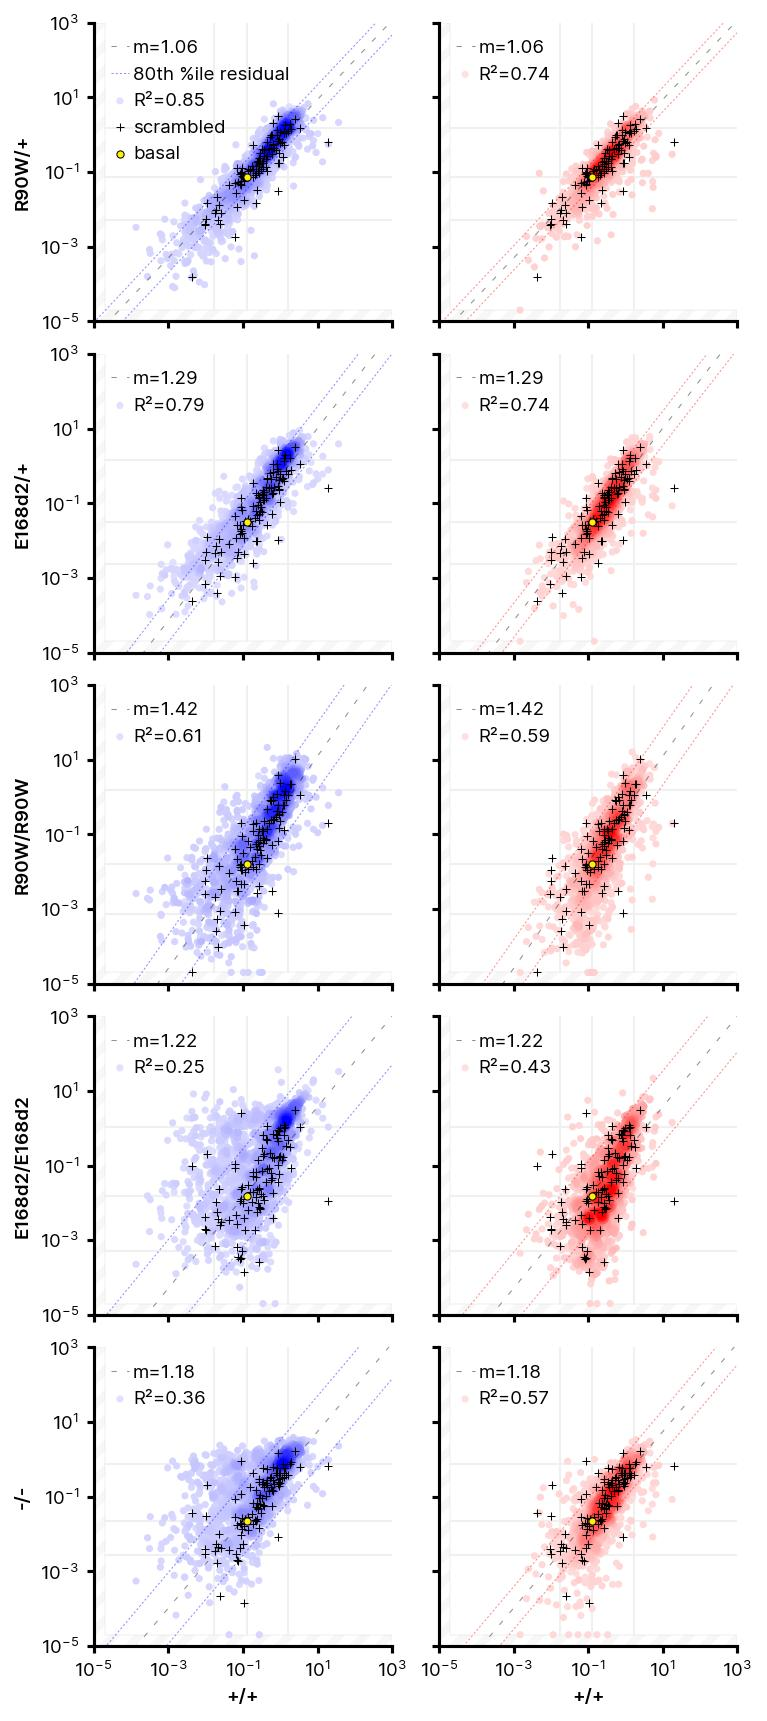

## [hsp68] Scatterplot correlation of CRE activity

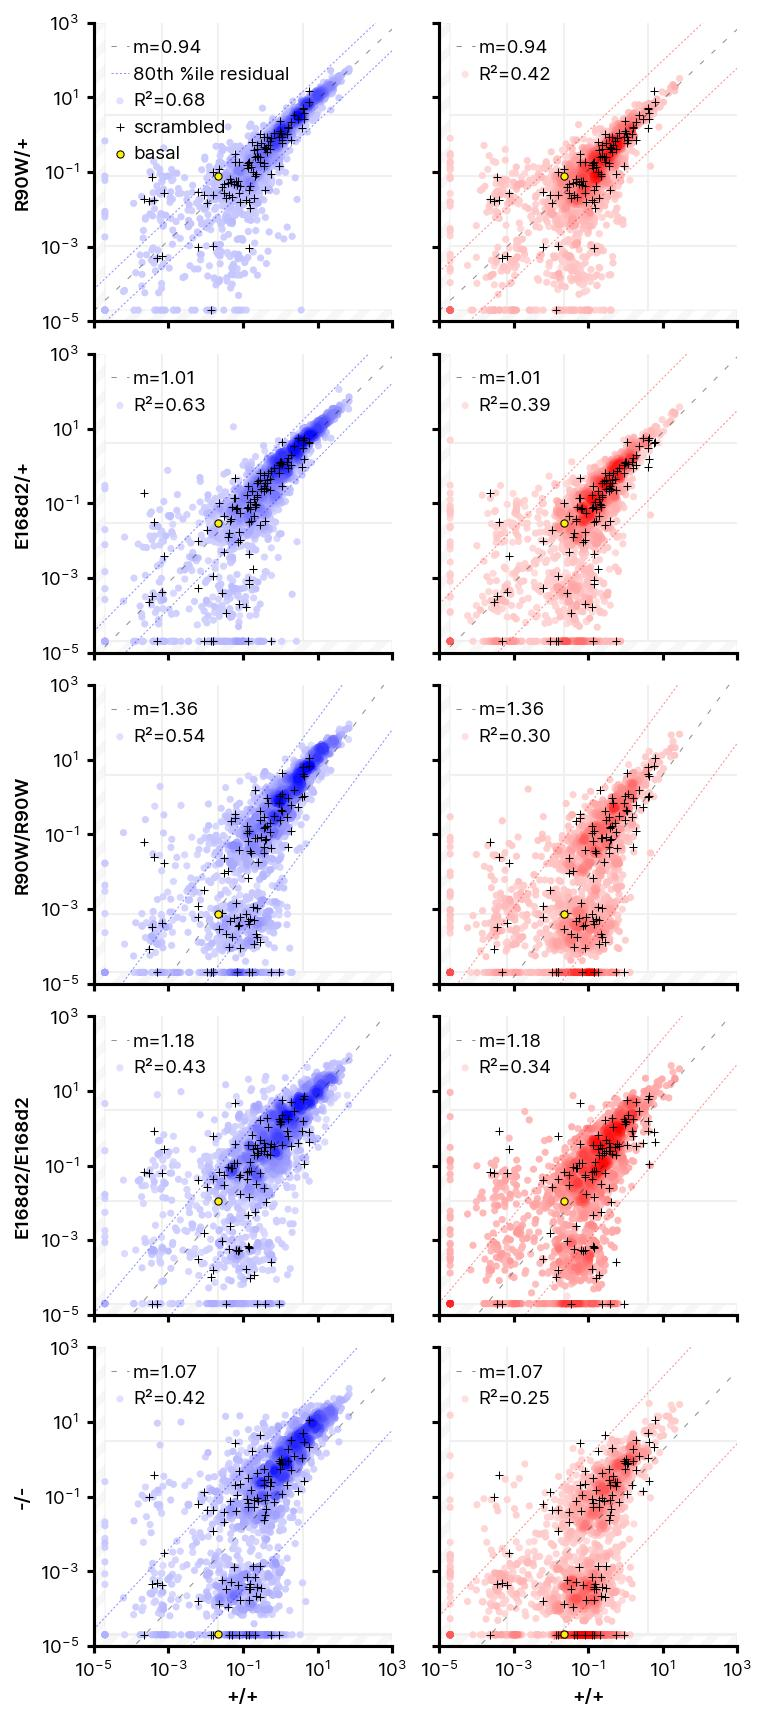

In [7]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Scatterplot correlation of CRE activity"))
    
    figure, axes = pyplot.subplots(nrows=5, ncols=2, sharex=True, sharey=False, figsize=(5, 12.5), layout="compressed")
    bounds = (1e-5, 1e3)
    
    axes_iter = axes.T.flat
    axis_index_iter = iter(range(len(axes.T.flat)))
    
    for variant_type, cmap, base_color in [("wildtype", cm_light_to_blue, "#0000ff"), ("allCrxSites", cm_light_to_red, "#ff0000")]:
    
        data = library_df.filter(polars.col("variant_type") == variant_type).with_columns([
            polars.col("activity_mean") + 2e-5
        ]).sort(["genotype", "library_id"]).pivot(values="activity_mean", index="library_id", columns="genotype", maintain_order=True).to_pandas()

        scrambled_data = library_df.filter(polars.col("variant_type") == "scrambled").with_columns([
            polars.col("activity_mean") + 2e-5
        ]).sort(["genotype", "library_id"]).pivot(values="activity_mean", index="library_id", columns="genotype", maintain_order=True).to_pandas()
        
        #display(data)
        #display(scrambled_data)

        genotype_comparisons = [
            ("WT", "Rhet"),
            ("WT", "Ehet"),
            ("WT", "Rhom"),
            ("WT", "Ehom"),
            ("WT", "CrxKO"),
        ]
        
        for (genotype1, genotype2), axis in zip(genotype_comparisons, axes_iter):
            index = next(axis_index_iter)
            
            # Define grid of bins for evaulating heatmap and lines
            bins = numpy.geomspace(start=bounds[0], stop=bounds[1], num=50)

            x = data[genotype1].to_numpy()
            y = data[genotype2].to_numpy()
            
            # Compute robust regression of scrambled sequences
            scrambled_x = scrambled_data[genotype1].to_numpy()
            scrambled_y = scrambled_data[genotype2].to_numpy()
            log_scrambled_x_with_intercept = statsmods.add_constant(numpy.log10(scrambled_x))

            rlm_results = statsmods.RLM(numpy.log10(scrambled_y), log_scrambled_x_with_intercept, M=statsmods.robust.norms.TrimmedMean(), missing="raise").fit()
            intercept, slope = rlm_results.params
            axis.plot(bins, numpy.power(10, rlm_results.predict(statsmods.add_constant(numpy.log10(bins)), transform=False)), color="#00000070", linestyle=(0, (5, 10)), linewidth=0.5, marker=None, label=f"m={slope:.2f}", zorder=2)
            
            data_rlm_residuals = numpy.abs(numpy.log10(y) - rlm_results.predict(statsmods.add_constant(numpy.log10(x))))
            data_rlm_residuals_bound = numpy.percentile(data_rlm_residuals, 80)
            axis.plot(bins, numpy.power(10, rlm_results.predict(statsmods.add_constant(numpy.log10(bins)), transform=False) + data_rlm_residuals_bound), color=base_color + "70", linestyle=(0, (2, 2)), linewidth=0.5, marker=None, label="80th %ile residual" if index == 0 else "_nolegend_", zorder=2)
            axis.plot(bins, numpy.power(10, rlm_results.predict(statsmods.add_constant(numpy.log10(bins)), transform=False) - data_rlm_residuals_bound), color=base_color + "70", linestyle=(0, (2, 2)), linewidth=0.5, marker=None, label="_nolegend_", zorder=2)

            # Calculate R^2
            fit = scipy.stats.linregress(numpy.log10(x), numpy.log10(y))
            fit_func = lambda x: fit.slope * x + fit.intercept
            
            # Plot CREs as a scatterplot colored by density
            weights, color_normalizer = calc_weights_for_scatter(x, y, bins=bins)
            axis.scatter(**reorder_points_and_weights(x, y, weights), cmap=cmap, norm=color_normalizer, s=6, marker="o", rasterized=True, label=f"R²={fit.rvalue**2:.2f}", zorder=0)

            # Plot scrambled sequences
            axis.scatter(scrambled_data[genotype1], scrambled_data[genotype2], marker="+", color="#000000", s=12, alpha=1, linewidth=0.5, label="scrambled" if index == 0 else "_nolegend_", rasterized=True, zorder=1)
            
            # Plot basal
            g1_basal_mean = library_df.filter((polars.col("genotype") == genotype1) & (polars.col("variant_type") == "basal"))["activity_mean"][0]
            g2_basal_mean = library_df.filter((polars.col("genotype") == genotype2) & (polars.col("variant_type") == "basal"))["activity_mean"][0]
            axis.scatter(g1_basal_mean, g2_basal_mean, marker="o", color="#fff200", edgecolor="#000000", s=12, linewidth=0.5, label="basal" if index == 0 else "_nolegend_", zorder=3)
            
            # Plot out-of-bounds
            axis.add_patch(matplotlib.patches.Polygon(
                xy=[(bounds[1], 2e-5), (2e-5, 2e-5), (2e-5, bounds[1]), (0, bounds[1]), (0, 0), (bounds[1], 0)],
                facecolor="#00000000",
                edgecolor="#00000008",
                hatch=r"//",
                zorder=-1
            ))
            
            g1_silencerbound = numpy.percentile(scrambled_data[genotype1], 5)
            g1_enhancerbound = numpy.percentile(scrambled_data[genotype1], 95)
            g2_silencerbound = numpy.percentile(scrambled_data[genotype2], 5)
            g2_enhancerbound = numpy.percentile(scrambled_data[genotype2], 95)
            
            axis.plot((g1_basal_mean, g1_basal_mean), (2e-5, bounds[1]), color="#f0f0f0", linewidth=1, zorder=-1)
            axis.plot((2e-5, bounds[1]), (g2_basal_mean, g2_basal_mean), color="#f0f0f0", linewidth=1, zorder=-1)
            
            axis.plot((g1_silencerbound, g1_silencerbound), (2e-5, bounds[1]), color="#f0f0f0", linewidth=1, zorder=-1)
            axis.plot((g1_enhancerbound, g1_enhancerbound), (2e-5, bounds[1]), color="#f0f0f0", linewidth=1, zorder=-1)
            
            axis.plot((2e-5, bounds[1]), (g2_silencerbound, g2_silencerbound), color="#f0f0f0", linewidth=1, zorder=-1)
            axis.plot((2e-5, bounds[1]), (g2_enhancerbound, g2_enhancerbound), color="#f0f0f0", linewidth=1, zorder=-1)
            
            # Format plot
            axis.set(xlim=bounds, ylim=bounds, xlabel="", ylabel="")
            axis.set_xscale("log", base=10)
            axis.set_yscale("log", base=10)
            axis.xaxis.set_major_locator(pyplot.LogLocator(numticks=5))
            axis.yaxis.set_major_locator(pyplot.LogLocator(numticks=5))
            
            if index < 5:
                axis.set(ylabel=translate_genotype_to_label(genotype2))
                axis.tick_params(which="major", left=True, right=False, labelleft=True, labelright=False)
            else:
                axis.tick_params(which="major", left=True, right=False, labelleft=False, labelright=False)
            if (index + 1)%5 == 0:
                axis.set(xlabel=translate_genotype_to_label(genotype1))
                axis.tick_params(which="major", bottom=True, top=False, labelbottom=True, labeltop=False)
            else:
                axis.tick_params(which="major", bottom=True, top=False, labelbottom=False, labeltop=False)
            axis.tick_params(which="minor", bottom=False, top=False, left=False, right=False)
            
            axis.set_aspect(aspect="equal", adjustable=None, anchor="C")

            handles, labels = axis.get_legend_handles_labels()
            legend = axis.legend(handles, labels, loc="upper left")

            
    figure.savefig(f"Figures/expression_across_genotypes_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

## [rho] Heatmap correlation of CRE classification

### wildtype

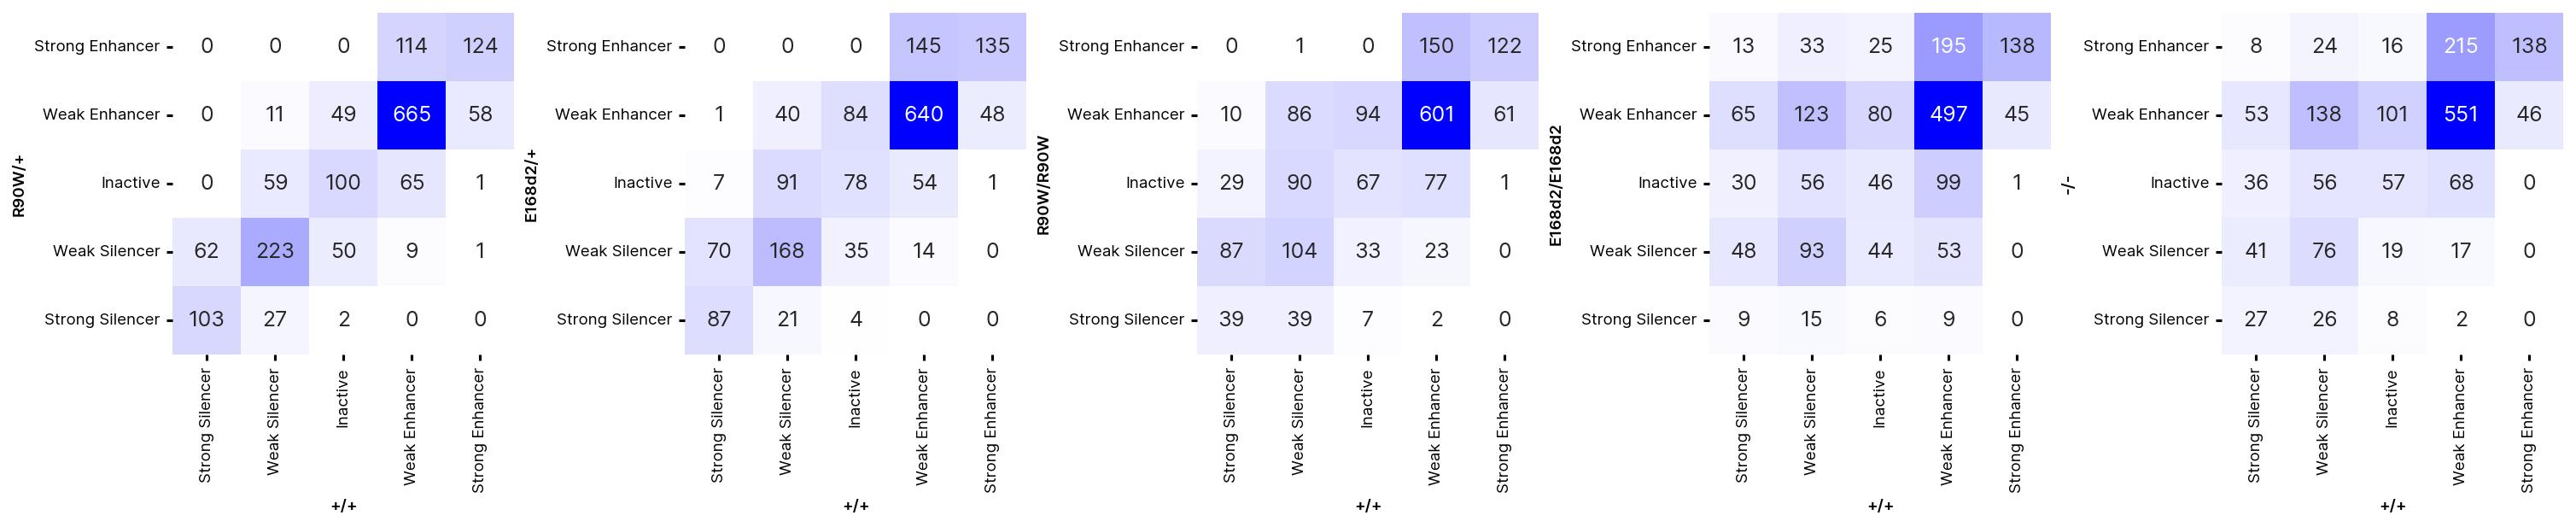

### allCrxSites

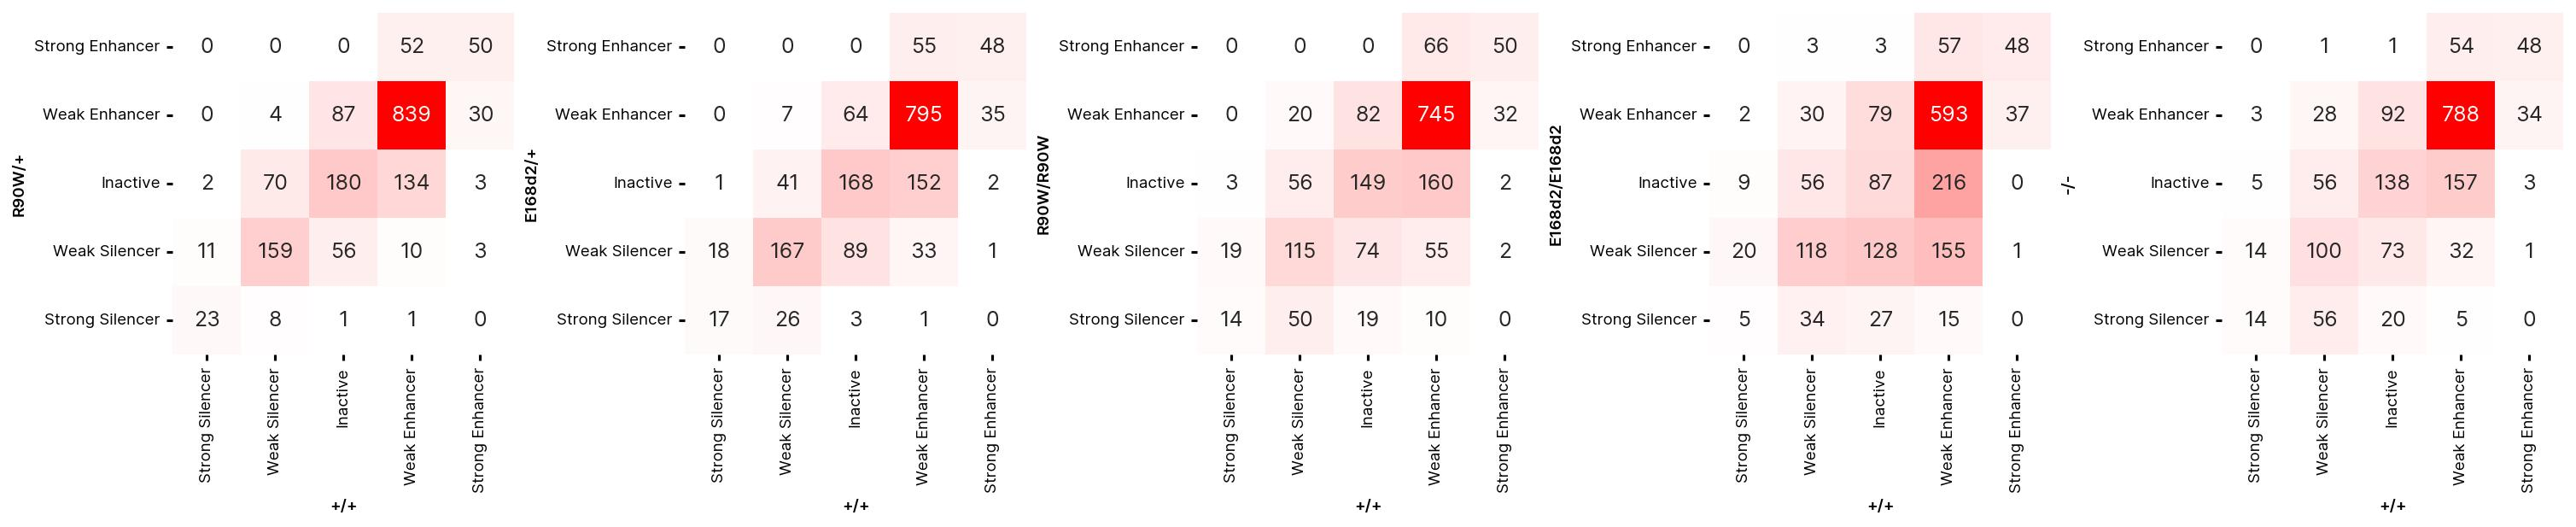

## [hsp68] Heatmap correlation of CRE classification

### wildtype

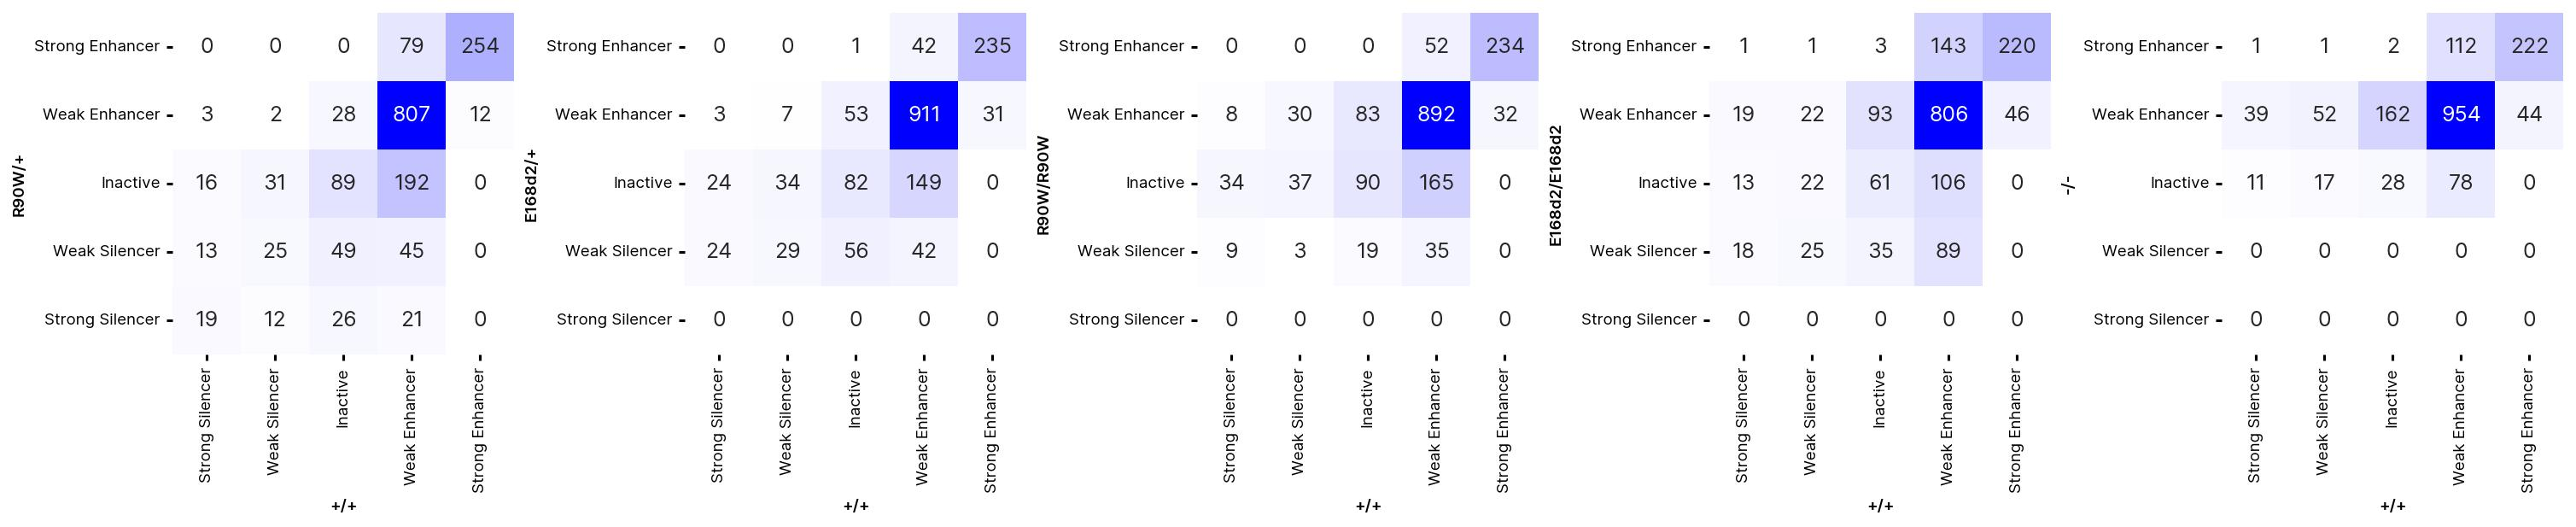

### allCrxSites

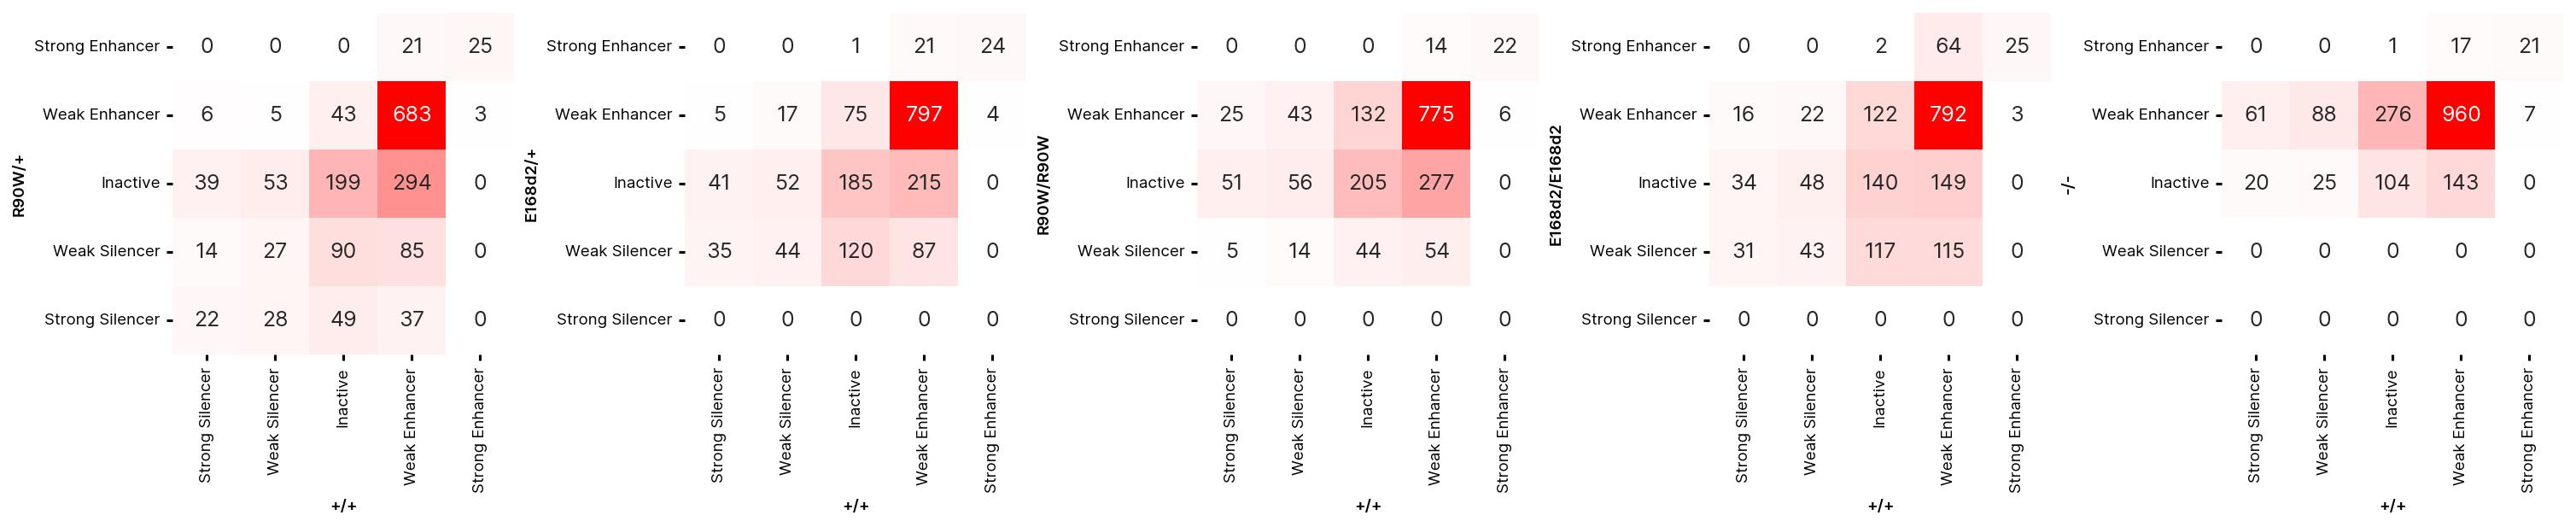

In [8]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Heatmap correlation of CRE classification"))
    
    for variant_type, cmap in [("wildtype", cm_white_to_blue), ("allCrxSites", cm_white_to_red)]:
        
        genotype_comparisons = [
            ("WT", "Rhet"),
            ("WT", "Ehet"),
            ("WT", "Rhom"),
            ("WT", "Ehom"),
            ("WT", "CrxKO"),
        ]

        figure, axes = pyplot.subplots(nrows=1, ncols=5, sharex=False, sharey=False, figsize=(20, 4), layout="compressed")

        activity_classes = ["strong_silencer", "weak_silencer", "inactive", "weak_enhancer", "strong_enhancer"]
        def clean_activity_class(raw):
            return " ".join(map(str.capitalize, raw.split("_")))
        
        for (genotype1, genotype2), axis in zip(genotype_comparisons, axes.flat):
            raw_intersections = {}
            for genotype1_activity_class in activity_classes:
                raw_intersections[clean_activity_class(genotype1_activity_class)] = {}
                for genotype2_activity_class in reversed(activity_classes):
                    genotype1_activity_class_ids = set(
                        library_df.filter(
                            (polars.col("genotype") == genotype1) &
                            (polars.col("variant_type") == variant_type) &
                            (polars.col("activity_class") == genotype1_activity_class)
                        )["chip_peak_id"]
                    )
                    genotype2_activity_class_ids = set(
                        library_df.filter(
                            (polars.col("genotype") == genotype2) &
                            (polars.col("variant_type") == variant_type) &
                            (polars.col("activity_class") == genotype2_activity_class)
                        )["chip_peak_id"]
                    )
                    intersection = genotype1_activity_class_ids & genotype2_activity_class_ids
                    raw_intersections[clean_activity_class(genotype1_activity_class)][clean_activity_class(genotype2_activity_class)] = len(intersection)
            intersections = pandas.DataFrame(raw_intersections)
            seaborn.heatmap(intersections, ax=axis, cmap=cmap, square=True, annot=True, fmt="d", cbar=False)
            axis.set(xlabel=translate_genotype_to_label(genotype1), ylabel=translate_genotype_to_label(genotype2))
            
            axis.set_aspect("equal", adjustable=None, anchor="C")

        for axis in axes.flat[len(genotype_comparisons):]:
            axis.axis("off")

        figure.savefig(f"Figures/activity_class_intersections_across_genotypes_{variant_type}_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
        display(Markdown(f"### {variant_type}"))
        display(figure)
        pyplot.close(figure)

## [rho] Scatterplot correlation of wt CRE vs mutant CRE activity

### allCrxSites

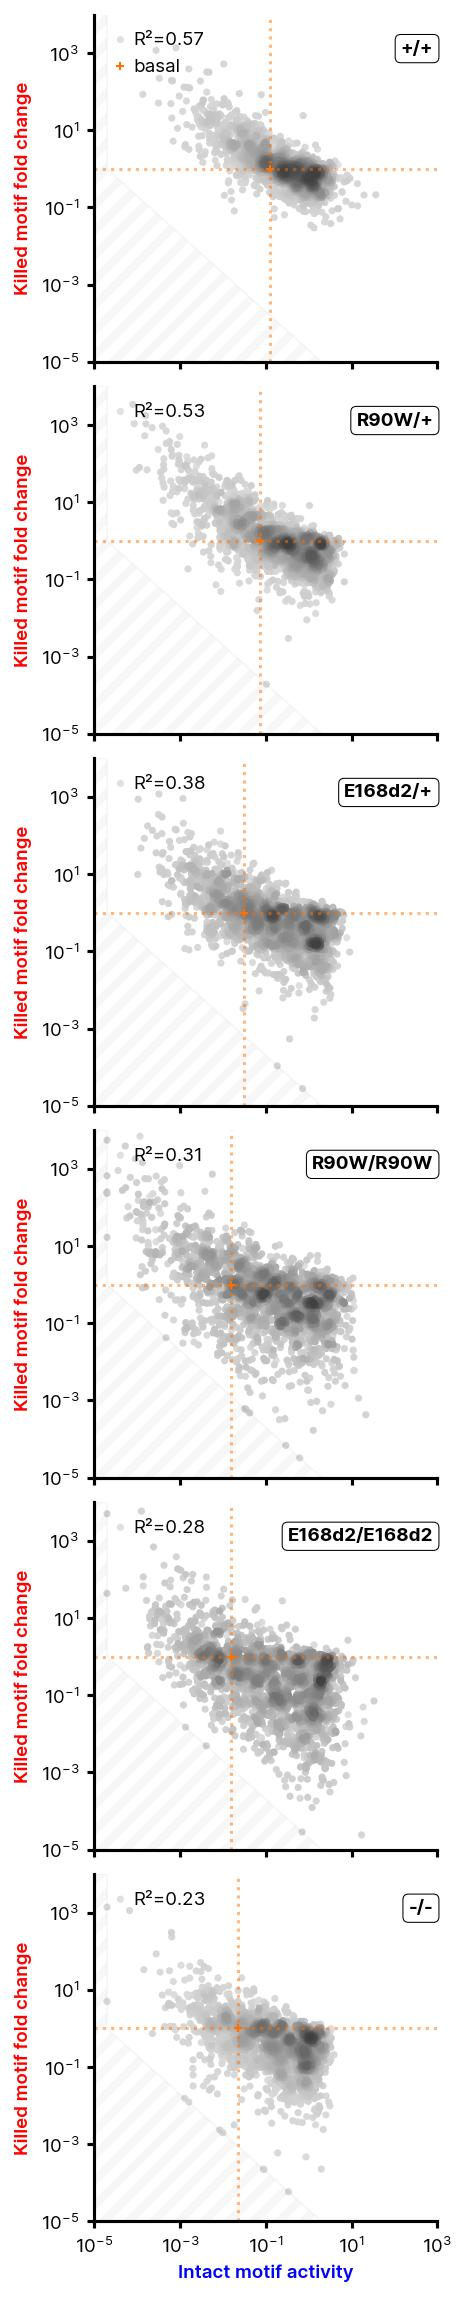

## [hsp68] Scatterplot correlation of wt CRE vs mutant CRE activity

### allCrxSites

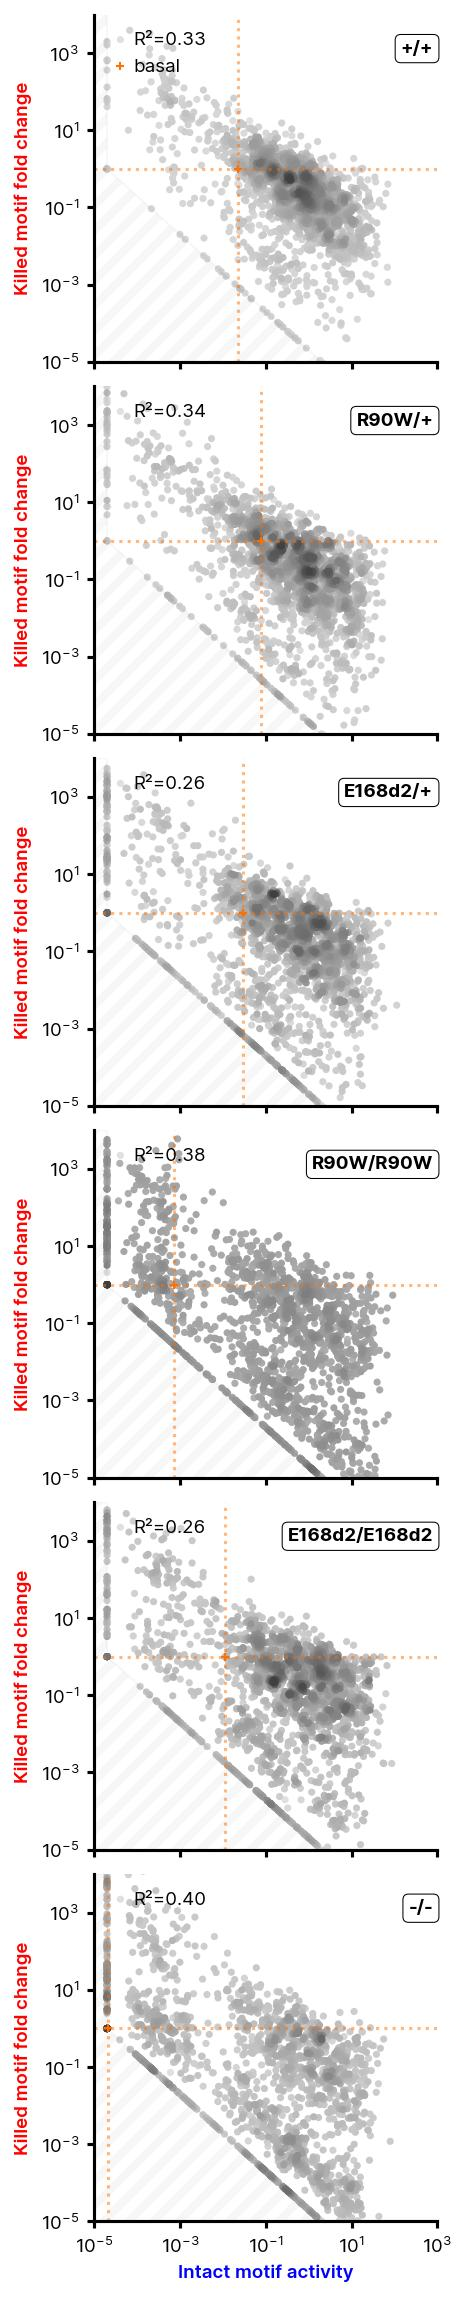

In [9]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Scatterplot correlation of wt CRE vs mutant CRE activity"))

    genotypes = [
        "WT",
        "Rhet",
        "Ehet",
        "Rhom",
        "Ehom",
        "CrxKO"
    ]

    figure, axes = pyplot.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(3, 15.2), layout="compressed")
    x_bounds = (1e-5, 1e3)
    y_bounds = (1e-5, 1e4)
    
    first_axis = axes.flat[0]

    for index, (genotype, axis) in enumerate(zip(genotypes, axes.flat)):
        
        data = library_df.filter((polars.col("genotype") == genotype) & ((polars.col("variant_type") == "wildtype") | (polars.col("variant_type") == "allCrxSites"))).with_columns([
            polars.col("activity_mean") + 2e-5
        ]).pivot(values="activity_mean", index="chip_peak_id", columns="variant_type").with_columns([
            (polars.col("allCrxSites")/polars.col("wildtype")).alias("foldChange")
        ]).to_pandas()
        
        #display(data)

        # Define grid of bins for evaulating heatmap and lines
        x_bins = numpy.geomspace(start=x_bounds[0], stop=y_bounds[1], num=50)
        y_bins = numpy.geomspace(start=y_bounds[0], stop=y_bounds[1], num=50)

        x = data["wildtype"].to_numpy()
        y = data["foldChange"].to_numpy()

        # Calculate R^2
        fit = scipy.stats.linregress(numpy.log10(x), numpy.log10(y))
        fit_func = lambda x: fit.slope * x + fit.intercept

        # Plot wildtype CREs as a scatterplot colored by density
        weights, color_normalizer = calc_weights_for_scatter(x, y, bins=(x_bins, y_bins))
        axis.scatter(**reorder_points_and_weights(x, y, weights), cmap=cm_light_to_gray, norm=color_normalizer, s=6, marker="o", rasterized=True, label=f"R²={fit.rvalue**2:.2f}")

        # Plot basal
        basal_mean = library_df.filter((polars.col("genotype") == genotype) & (polars.col("variant_type") == "basal"))["activity_mean"][0]
        axis.scatter(basal_mean, 1, marker="+", color="#ff7000", s=16, linewidth=1, label="basal" if index == 0 else "_nolegend_")
        axis.axvline(x=basal_mean, color="#ff700080", linewidth=1.5, linestyle=":")
        axis.axhline(y=1, color="#ff700080", linewidth=1.5, linestyle=":")
        
        # Plot out-of-bounds        
        axis.add_patch(matplotlib.patches.Polygon(
            xy=[(1e3, 2e-5/1e3), (2e-5, 1), (2e-5, 1e4), (0, 1e4), (0, 0)],
            facecolor="#00000000",
            edgecolor="#00000008",
            hatch=r"//"
        ))
        
        axis.text(8e2, 10e2, translate_genotype_to_label(genotype), fontsize=9, fontweight="bold", horizontalalignment="right", fontfamily="Inter", bbox={"boxstyle": "round", "facecolor": "#ffffff00", "linewidth": 0.5})
        
        # Format plot
        axis.set(xlim=x_bounds, ylim=y_bounds, ylabel="Killed motif fold change")
        axis.xaxis.label.set_color("#0000ff")
        axis.yaxis.label.set_color("#ff0000")
        axis.set_xscale("log", base=10)
        axis.set_yscale("log", base=10)
        axis.xaxis.set_major_locator(pyplot.LogLocator(numticks=5))
        axis.yaxis.set_major_locator(pyplot.LogLocator(numticks=7))
        if (index + 1)%6 == 0:
            axis.set(xlabel="Intact motif activity")
            axis.tick_params(which="major", bottom=True, top=False, left=True, right=False, labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        else:
            axis.tick_params(which="major", bottom=True, top=False, left=True, right=False, labelbottom=False, labeltop=False, labelleft=True, labelright=False)
        axis.tick_params(which="minor", bottom=False, top=False, left=False, right=False)
        #axis.set_aspect(aspect="equal", adjustable=None, anchor="C")

        handles, labels = axis.get_legend_handles_labels()
        legend = axis.legend(handles, labels, loc="upper left")

    figure.savefig(f"Figures/expression_wt_vs_crxMut_motifs_{variant_type}_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(Markdown(f"### {variant_type}"))
    display(figure)
    pyplot.close(figure)

## [rho] Heatmap correlation of wt CRE vs mutant CRE classification

### allCrxSites

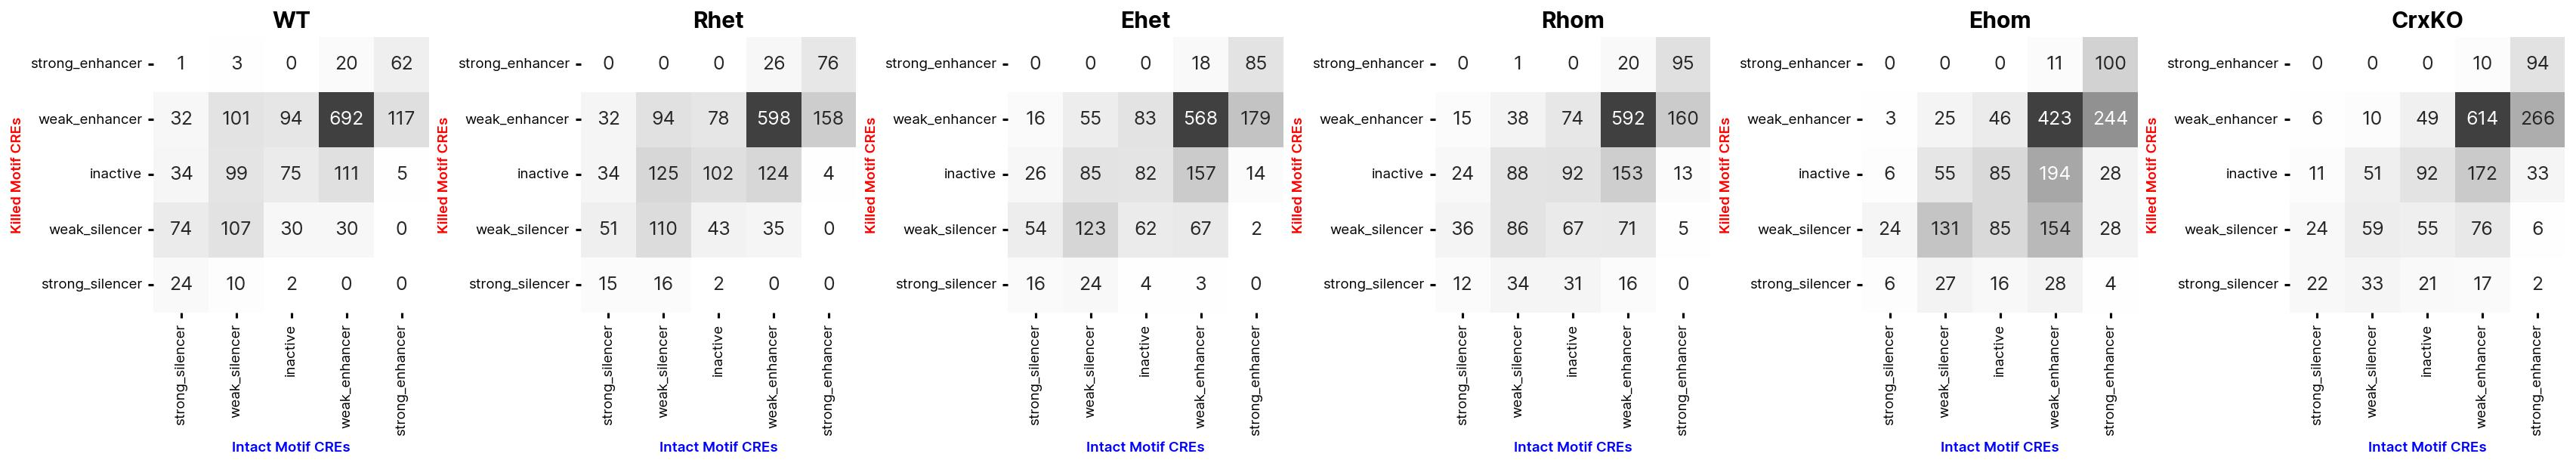

## [hsp68] Heatmap correlation of wt CRE vs mutant CRE classification

### allCrxSites

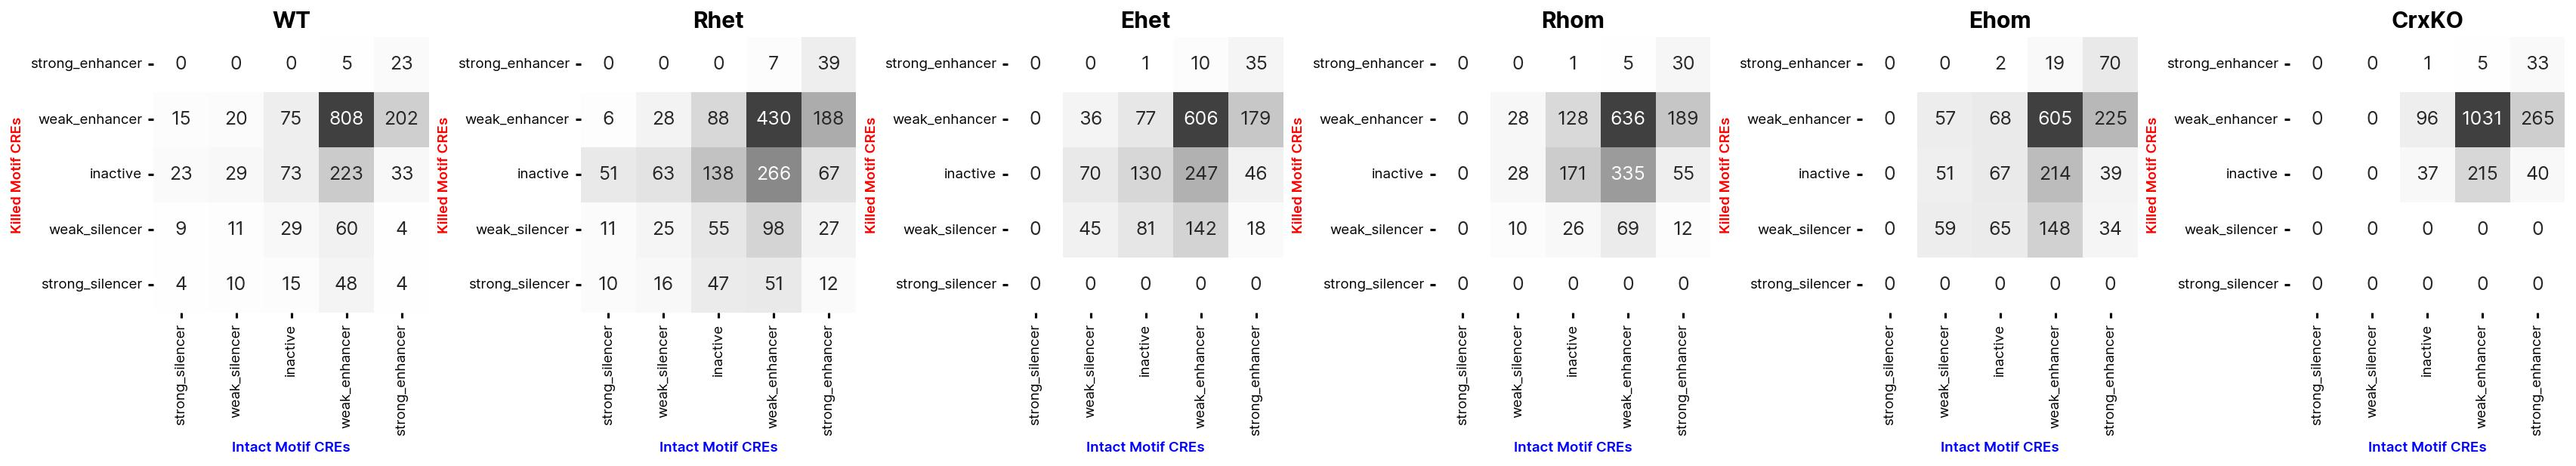

In [10]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Heatmap correlation of wt CRE vs mutant CRE classification"))
    
    genotypes = [
        "WT",
        "Rhet",
        "Ehet",
        "Rhom",
        "Ehom",
        "CrxKO"
    ]
    
    figure, axes = pyplot.subplots(nrows=1, ncols=6, sharex=False, sharey=False, figsize=(24, 4), layout="compressed")
    
    for index, (genotype, axis) in enumerate(zip(genotypes, axes.flat)):
        activity_classes = ["strong_silencer", "weak_silencer", "inactive", "weak_enhancer", "strong_enhancer"]

        raw_intersections = {}
        for wtMotif_activity_class in activity_classes:
            raw_intersections[wtMotif_activity_class] = {}
            for mutMotif_activity_class in reversed(activity_classes):
                wtMotif_activity_class_ids = set(
                    library_df.filter(
                        (polars.col("genotype") == genotype) &
                        (polars.col("variant_type") == "wildtype") &
                        (polars.col("activity_class") == wtMotif_activity_class)
                    )["chip_peak_id"]
                )
                mutMotif_activity_class_ids = set(
                    library_df.filter(
                        (polars.col("genotype") == genotype) &
                        (polars.col("variant_type") == "allCrxSites") &
                        (polars.col("activity_class") == mutMotif_activity_class)
                    )["chip_peak_id"]
                )
                
                intersection = wtMotif_activity_class_ids & mutMotif_activity_class_ids
                raw_intersections[wtMotif_activity_class][mutMotif_activity_class] = len(intersection)
        intersections = pandas.DataFrame(raw_intersections)
        seaborn.heatmap(intersections, ax=axis, cmap=cm_white_to_gray, square=True, annot=True, fmt="d", cbar=False)
        axis.set(xlabel="Intact Motif CREs", ylabel="Killed Motif CREs", title=f"{genotype}")
        axis.xaxis.label.set_color("#0000ff")
        axis.yaxis.label.set_color("#ff0000")

        axis.set_aspect("equal", adjustable=None, anchor="C")

    for axis in axes.flat[len(genotypes):]:
        axis.axis("off")

    figure.savefig(f"Figures/activity_class_intersections_wt_vs_crxMut_motifs_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(Markdown(f"### {variant_type}"))
    display(figure)
    pyplot.close(figure)

## [rho] Heatmap of CRE activity across all genotypes

,+/+,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,,
CRX.3178,0.001306,0.000086,0.001749,0.002645,1.398323,0.895352
CRX.4758,0.000961,0.000480,0.007666,0.023227,0.476186,0.589809
CRX.2672,0.001679,0.001279,0.001692,0.004851,0.714902,0.665655
CRX.2198,0.004741,0.000225,0.001843,0.000444,8.298077,1.232420
CRX.3311,0.004280,0.003702,0.003583,0.024366,2.814048,0.981043
...,...,...,...,...,...,...
CRX.4432,0.122101,0.012937,0.004219,0.008252,0.008015,0.000545
CRX.4956,0.170923,0.026123,0.010861,0.000096,0.000199,0.000456
CRX.3289,0.267390,0.336549,0.390009,0.058876,0.013221,0.000570


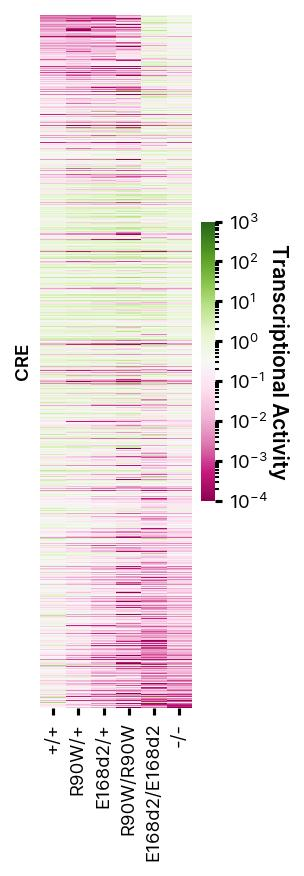

## [hsp68] Heatmap of CRE activity across all genotypes

,+/+,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,,
CRX.3311,0.000511,0.000505,0.002095,0.001797,7.892644,9.343298
CRX.4361,0.000020,0.006321,0.007754,0.000020,0.000020,0.253942
CRX.2836,0.002188,0.006334,0.006811,0.597542,9.535618,9.994803
CRX.3743,0.000603,0.025694,0.000020,1.914034,0.218676,2.428669
CRX.3981,0.000020,0.000020,0.000020,0.002996,4.579507,0.020853
...,...,...,...,...,...,...
CRX.2815,1.105887,0.397202,0.102699,0.050446,0.000020,0.000020
CRX.1973,1.259134,0.457042,0.198797,0.086474,0.192176,0.000020
CRX.4350,1.510849,0.225353,0.198480,0.000381,0.165231,0.000020


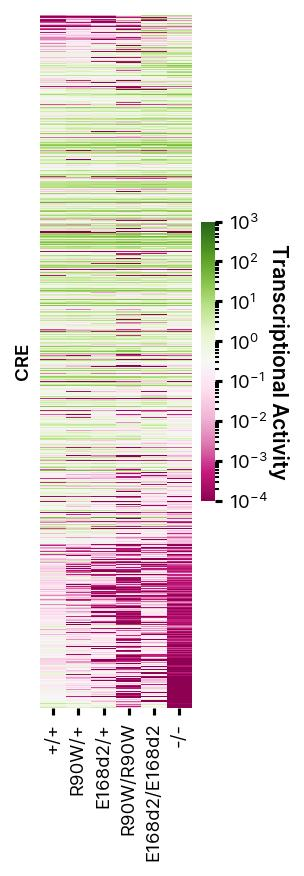

In [11]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Heatmap of CRE activity across all genotypes"))
    
    processed_data = library_df.filter(polars.col("variant_type") == "wildtype")

    heatmap_data = processed_data.with_columns([
        polars.col("activity_mean") + 2e-5
    ]).pivot(values="activity_mean", index="chip_peak_id", columns="genotype").select([
        "chip_peak_id",
        "WT",
        "Rhet",
        "Ehet",
        "Rhom",
        "Ehom",
        "CrxKO"
    ]).sort(polars.col("CrxKO")/polars.col("WT"), descending=True).rename(NAME_TRANSLATION_TABLE)
    
    activity_df = heatmap_data.to_pandas().set_index("CRE")
    display(activity_df)
    
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(1.5, 6))
    
    axes = seaborn.heatmap(axes=axes, data=activity_df, cmap="PiYG", norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e3, clip=True), yticklabels=False, rasterized=True, cbar_kws={"fraction": 0.08})
    axes.collections[0].colorbar.ax.set_ylabel("Transcriptional Activity", rotation=270, labelpad=10, fontsize=10)
    figure.savefig(f"Figures/element_activity_heatmap_across_genotypes_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

---

# CONVERTED SILENCERS

---

## [rho] Subgroup intersections

### wt_silencers_converted_in_e168d2 and wt_silencers_converted_in_crxko

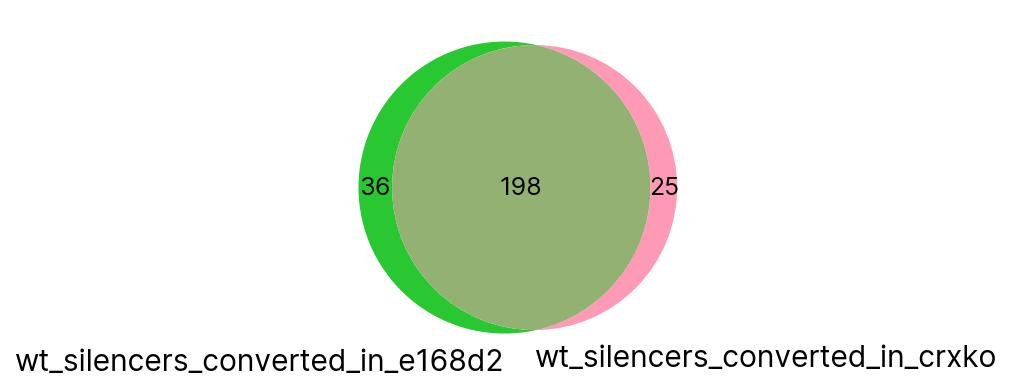

## [hsp68] Subgroup intersections

### wt_silencers_converted_in_e168d2 and wt_silencers_converted_in_crxko

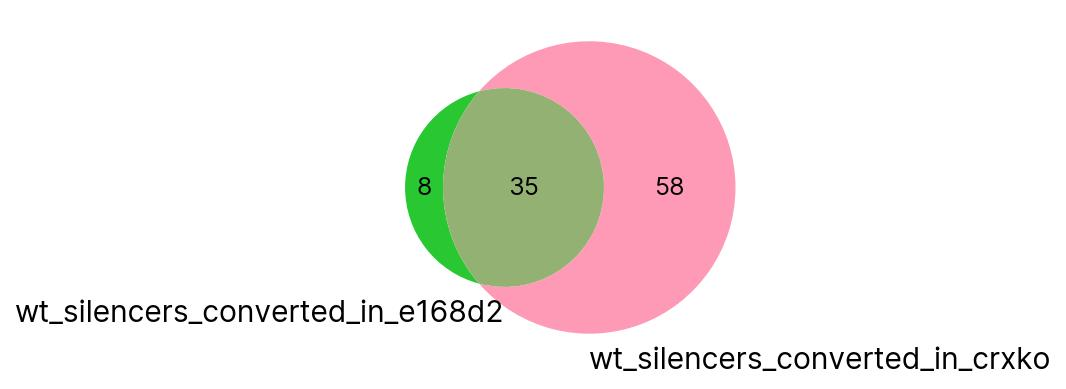

## [rho] Subgroup sizes

 - wt_silencers: 485 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_rho.fa`)
 - wt_enhancers: 1037 elements (wrote CRE sequences to `Motif_Analysis/wt_enhancers_rho.fa`)
 - wt_silencers_converted_in_e168d2: 234 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_converted_in_e168d2_rho.fa`)
 - wt_silencers_not_converted_in_e168d2: 251 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_not_converted_in_e168d2_rho.fa`)
 - wt_silencers_converted_in_crxko: 223 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_converted_in_crxko_rho.fa`)


## [hsp68] Subgroup sizes

 - wt_silencers: 121 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_hsp68.fa`)
 - wt_enhancers: 1410 elements (wrote CRE sequences to `Motif_Analysis/wt_enhancers_hsp68.fa`)
 - wt_silencers_converted_in_e168d2: 43 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_converted_in_e168d2_hsp68.fa`)
 - wt_silencers_not_converted_in_e168d2: 78 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_not_converted_in_e168d2_hsp68.fa`)
 - wt_silencers_converted_in_crxko: 93 elements (wrote CRE sequences to `Motif_Analysis/wt_silencers_converted_in_crxko_hsp68.fa`)


In [12]:
element_subgroups = {}

for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    
    if library_name not in element_subgroups:
        element_subgroups[library_name] = {}
    
    element_subgroups[library_name]["wt_silencers"] = library_df.filter(
        (polars.col("variant_type") == "wildtype") &
        (polars.col("genotype") == "WT") &
        ((polars.col("activity_class") == "strong_silencer") | (polars.col("activity_class") == "weak_silencer"))
    )["chip_peak_id"]
    
    element_subgroups[library_name]["wt_enhancers"] = library_df.filter(
        (polars.col("variant_type") == "wildtype") &
        (polars.col("genotype") == "WT") &
        ((polars.col("activity_class") == "weak_enhancer") | (polars.col("activity_class") == "strong_enhancer"))
    )["chip_peak_id"]
    
    e168d2_df = library_df.filter(
        (polars.col("variant_type") == "wildtype") &
        (polars.col("genotype") == "WT")
    ).select([
        polars.col("chip_peak_id"),
        polars.col("activity_class").alias("activity_class_WT")
    ]).join(
        library_df.filter(
            (polars.col("variant_type") == "wildtype") &
            (polars.col("genotype") == "Ehom")
        ).select([
            polars.col("chip_peak_id"),
            polars.col("activity_class").alias("activity_class_Ehom")
        ]), how="left", on="chip_peak_id"
    )
    
    element_subgroups[library_name]["wt_silencers_converted_in_e168d2"] = e168d2_df.filter(
        ((polars.col("activity_class_WT") == "strong_silencer") | (polars.col("activity_class_WT") == "weak_silencer")) &
        ((polars.col("activity_class_Ehom") == "weak_enhancer") | (polars.col("activity_class_Ehom") == "strong_enhancer"))
    )["chip_peak_id"]
    
    element_subgroups[library_name]["wt_silencers_not_converted_in_e168d2"] = e168d2_df.filter(
        ((polars.col("activity_class_WT") == "strong_silencer") | (polars.col("activity_class_WT") == "weak_silencer")) &
        ((polars.col("activity_class_Ehom") == "weak_enhancer") | (polars.col("activity_class_Ehom") == "strong_enhancer")).not_()
    )["chip_peak_id"]
    
    element_subgroups[library_name]["wt_silencers_converted_in_crxko"] = library_df.filter(
        (polars.col("variant_type") == "wildtype") &
        (polars.col("genotype") == "WT")
    ).select([
        "chip_peak_id",
        polars.col("activity_class").alias("activity_class_WT")
    ]).join(
        library_df.filter(
            (polars.col("variant_type") == "wildtype") &
            (polars.col("genotype") == "CrxKO")
        ).select([
            "chip_peak_id",
            polars.col("activity_class").alias("activity_class_CrxKO")
        ]), how="left", on="chip_peak_id"
    ).filter(
        ((polars.col("activity_class_WT") == "strong_silencer") | (polars.col("activity_class_WT") == "weak_silencer")) &
        ((polars.col("activity_class_CrxKO") == "weak_enhancer") | (polars.col("activity_class_CrxKO") == "strong_enhancer"))
    )["chip_peak_id"]

for library_name in ["rho", "hsp68"]:
    
    display(Markdown(f"## [{library_name}] Subgroup intersections"))
    
    subgroup_comparisons = [
        ("wt_silencers_converted_in_e168d2", "wt_silencers_converted_in_crxko")
    ]
    
    for (subgroup1, subgroup2) in subgroup_comparisons:
        display(Markdown(f"### {subgroup1} and {subgroup2}"))

        figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4, 3))

        venn = venn2([set(element_subgroups[library_name][subgroup1]), set(element_subgroups[library_name][subgroup2])], ax=axes)
        venn.get_label_by_id("A").set_text(subgroup1)
        venn.get_label_by_id("B").set_text(subgroup2)

        venn.patches[0].set_facecolor("#29C732")
        venn.patches[0].set_alpha(1.0)

        venn.patches[1].set_facecolor("#FF9AB6")
        venn.patches[1].set_alpha(1.0)
        
        if venn.patches[2] is not None:
            venn.patches[2].set_facecolor("#94B174")
            venn.patches[2].set_alpha(1.0)

        figure.savefig(f"Figures/overlap_{subgroup1}_vs_{subgroup2}_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
        display(figure)
        pyplot.close(figure)
 
for library in element_subgroups:
    display(Markdown(f"## [{library}] Subgroup sizes"))
    list_string = ""
    for subgroup in element_subgroups[library]:
        matching_CRE_sequences = library_metadata.filter(
            (polars.col("chip_peak_id").is_in(element_subgroups[library][subgroup])) &
            (polars.col("variant_type") == "wildtype")
        ).select(["chip_peak_id", "CRE_sequence"])
        output_file_name = f"Motif_Analysis/{subgroup}_{library}.fa"
        with open(output_file_name, "w") as out:
            for (chip_peak_id, CRE_sequence) in matching_CRE_sequences.iter_rows():
                out.write(f">{chip_peak_id}\n{CRE_sequence}\n")
        
        list_string += f" - {subgroup}: {len(element_subgroups[library][subgroup])} elements (wrote CRE sequences to `{output_file_name}`)\n"
        
    display(Markdown(list_string))

## [rho] Activity of subgroups

### wt_silencers_converted_in_e168d2

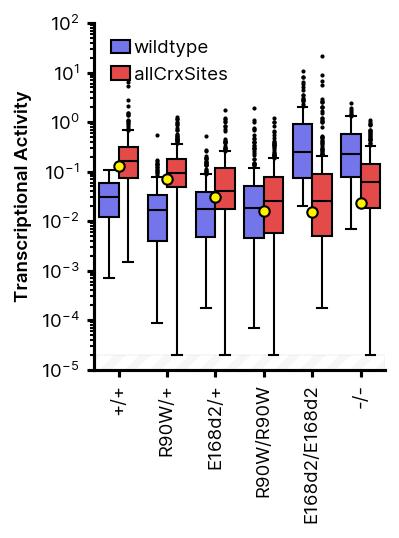

### wt_silencers_not_converted_in_e168d2

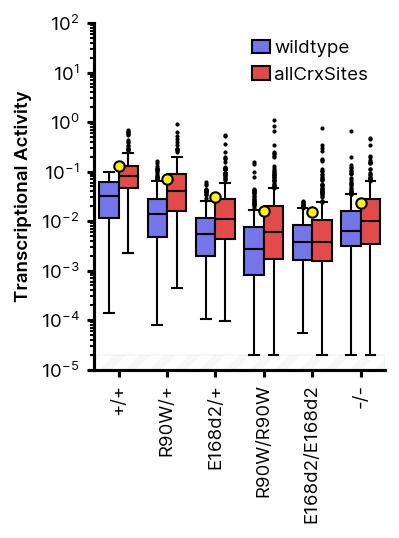

## [hsp68] Activity of subgroups

### wt_silencers_converted_in_e168d2

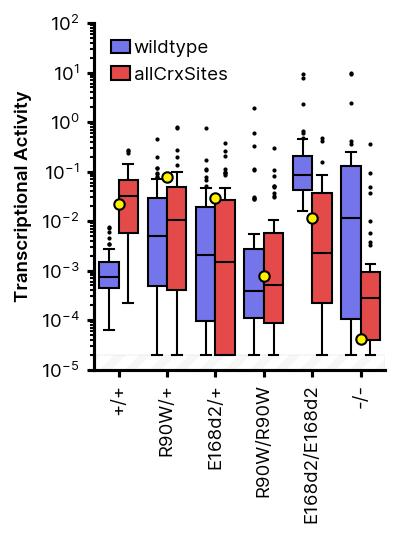

### wt_silencers_not_converted_in_e168d2

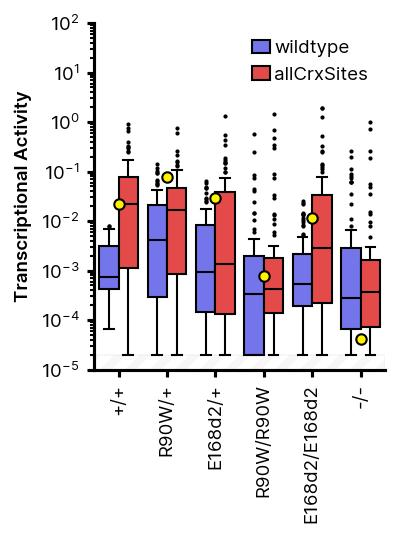

In [13]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Activity of subgroups"))
    
    basal_data = library_df.filter(
        (polars.col("library_id") == "basal")
    ).with_columns([
        polars.col("activity_mean") + 2e-5
    ]).with_columns([
        polars.col("genotype").map_dict(NAME_TRANSLATION_TABLE)
    ]).select([
        "genotype",
        "activity_mean",
    ]).to_pandas()
    
    for subgroup_name in ["wt_silencers_converted_in_e168d2", "wt_silencers_not_converted_in_e168d2"]:
    
        display(Markdown(f"### {subgroup_name}"))

        processed_data = library_df.filter(
            ((polars.col("variant_type") == "wildtype") | (polars.col("variant_type") == "allCrxSites")) &
            polars.col("chip_peak_id").is_in(element_subgroups[library_name][subgroup_name])
        ).with_columns([
            polars.col("activity_mean") + 2e-5
        ]).with_columns([
            polars.col("genotype").map_dict(NAME_TRANSLATION_TABLE)
        ]).to_pandas()

        figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(2.5, 3))

        plot_data_params = dict(
            data=processed_data,
            x="genotype",
            y="activity_mean",
            hue="variant_type",
            order=["+/+", "R90W/+", "E168d2/+", "R90W/R90W", "E168d2/E168d2", "-/-"],
            hue_order=["wildtype", "allCrxSites"],
        )
        _ = seaborn.boxplot(ax=axes, **plot_data_params, notch=False, palette=["#6060ff", "#ff3030"], linewidth=1, **boxplot_style_args)

        _ = seaborn.swarmplot(ax=axes, data=basal_data, x="genotype", y="activity_mean", order=["+/+", "R90W/+", "E168d2/+", "R90W/R90W", "E168d2/E168d2", "-/-"], s=5, color="#fff200", edgecolor="#000000", linewidth=1)

        # Plot out-of-bounds
        axes.add_patch(matplotlib.patches.Polygon(
            xy=[(-0.5, 2e-5), (len(plot_data_params["order"]) - 0.5, 2e-5), (len(plot_data_params["order"]) - 0.5, 0), (0, 0)],
            facecolor="#00000000",
            edgecolor="#00000008",
            hatch=r"//"
        ))

        axes.set(ylim=(1e-5, 1e2), xlabel=None, ylabel="Transcriptional Activity")
        axes.set_yscale("log")
        axes.tick_params(axis="x", rotation=90)

        figure.savefig(f"Figures/subgroup_activity_{subgroup_name}_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
        display(figure)
        pyplot.close(figure)

---

# COOPERATIVITY OF CRX SITES

---

## [rho] Cooperativity of CREs

,+/+,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,,
CRX.1907,0.034394,-0.287282,-0.074230,-2.099770,3.147288,2.511438
CRX.180,1.044998,2.191885,-0.451414,0.051607,-40.114186,31.113993
CRX.6342,0.312561,-1.372362,-0.037303,0.606054,2.685951,6.779537
CRX.3476,0.051390,0.249464,1.246034,0.989584,1.391963,1.113568
CRX.55,0.098679,7.734895,2.585195,-2.559457,3.093973,1.159988
...,...,...,...,...,...,...
CRX.4138,0.837411,1.450165,-0.544443,0.437693,-2.307554,-2.482011
CRX.1941,-0.068133,-0.156260,-0.100708,-0.144504,-2.701544,0.208014
CRX.1991,20.421987,38.284189,-917.888540,127.261273,-82.735324,-63.316112


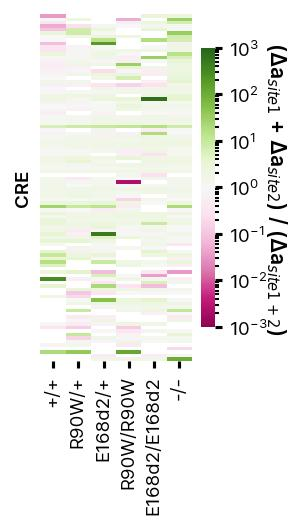

## [hsp68] Cooperativity of CREs

,+/+,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,,
CRX.4439,9.365275,18.604846,242.582685,1245.160428,143.964084,1.133126e+04
CRX.3731,1.832736,-2.053856,-7.065081,2.222590,10.040523,3.126846e+02
CRX.5822,-0.015506,2.866786,1.458332,-28.053009,-1.620356,-1.856814e+00
CRX.4379,1.806326,0.434700,2.054259,0.269027,-0.718310,1.098801e+02
CRX.978,0.034696,1.949295,1.900915,1.906250,1.905422,1.966001e+00
...,...,...,...,...,...,...
CRX.4809,-0.137727,-0.382527,-0.257749,5.482638,-1.316429,1.375442e+01
CRX.2783,0.153447,0.452571,0.511811,1.503937,1.252667,-1.976064e+01
CRX.332,-2.455351,-2.023018,10.770017,3.031923,-0.153434,1.071810e+03


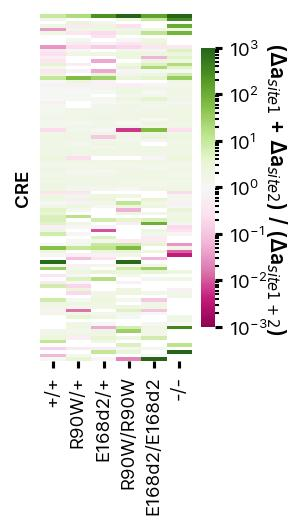

In [14]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Cooperativity of CREs"))
    
    data = library_df.with_columns([
        polars.col("activity_mean") + 2e-5
    ]).filter(polars.col("num_crx_sites") == 2).sort(["chip_peak_id", "genotype", "variant_type"]).with_columns([
        polars.when(polars.col("library_id").str.ends_with("_1_double")).then(1).when(polars.col("library_id").str.ends_with("2_double")).then(2).otherwise(None).alias("single_site_num"),
    ])
    
    processed_data = data.filter(polars.col("variant_type") == "wildtype").join(
        data.filter((polars.col("variant_type") == "singleCrxSite") & (polars.col("single_site_num") == 1)),
        how="inner", on=["genotype", "chip_peak_id"], suffix="_single1"
    ).join(
        data.filter((polars.col("variant_type") == "singleCrxSite") & (polars.col("single_site_num") == 2)),
        how="inner", on=["genotype", "chip_peak_id"], suffix="_single2"
    ).join(
        data.filter((polars.col("variant_type") == "allCrxSites")),
        how="inner", on=["genotype", "chip_peak_id"], suffix="_allSites"
    ).with_columns([
        #((polars.col("activity_mean_allSites") - polars.col("activity_mean")) - (polars.col("activity_mean_single1") - polars.col("activity_mean")) - (polars.col("activity_mean_single2") - polars.col("activity_mean"))).alias("double_single_activity_difference")
        #((polars.col("activity_mu_allSites") - polars.col("activity_mu")) - (polars.col("activity_mu_single1") - polars.col("activity_mu")) - (polars.col("activity_mu_single2") - polars.col("activity_mu"))).fill_nan(0).alias("double_single_activity_difference")
        (((polars.col("activity_mean") - polars.col("activity_mean_single1")) + (polars.col("activity_mean") - polars.col("activity_mean_single2")))/(polars.col("activity_mean") - polars.col("activity_mean_allSites"))).fill_nan(0).alias("double_single_activity_difference")
    ])
    
    heatmap_data = processed_data.pivot(values="double_single_activity_difference", index="chip_peak_id", columns="genotype").select([
        "chip_peak_id",
        "WT",
        "Rhet",
        "Ehet",
        "Rhom",
        "Ehom",
        "CrxKO"
    ]).sort(polars.col("CrxKO")/polars.col("WT"), descending=True).rename(NAME_TRANSLATION_TABLE).to_pandas().set_index("CRE")
    display(heatmap_data)
    
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(1.5, 3))
    
    axes = seaborn.heatmap(axes=axes, data=heatmap_data, cmap="PiYG", norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1e3), yticklabels=False, rasterized=True, cbar_kws={"fraction": 0.08, "label": "Transcriptional Activity"})
    axes.collections[0].colorbar.ax.set_ylabel("(Δa$_{site1}$ + Δa$_{site2}$) / (Δa$_{site1+2}$)", rotation=270, labelpad=10, fontsize=10)
    figure.savefig(f"Figures/cooperativity_across_genotypes_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

---

# CHROMATIN STATE

---

## [rho] Fraction of Activity Classifications by chromatin annotation of CRE genomic origin in +/+

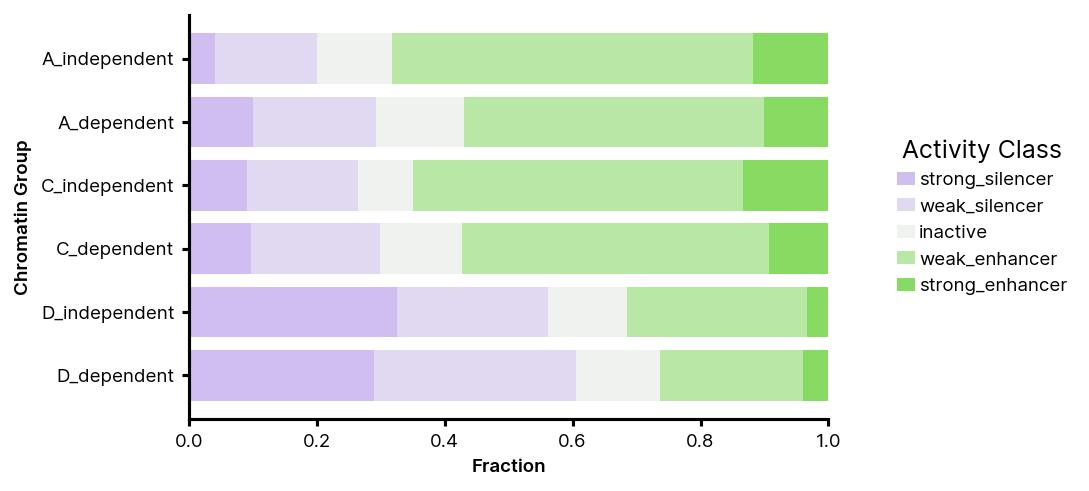

## [hsp68] Fraction of Activity Classifications by chromatin annotation of CRE genomic origin in +/+

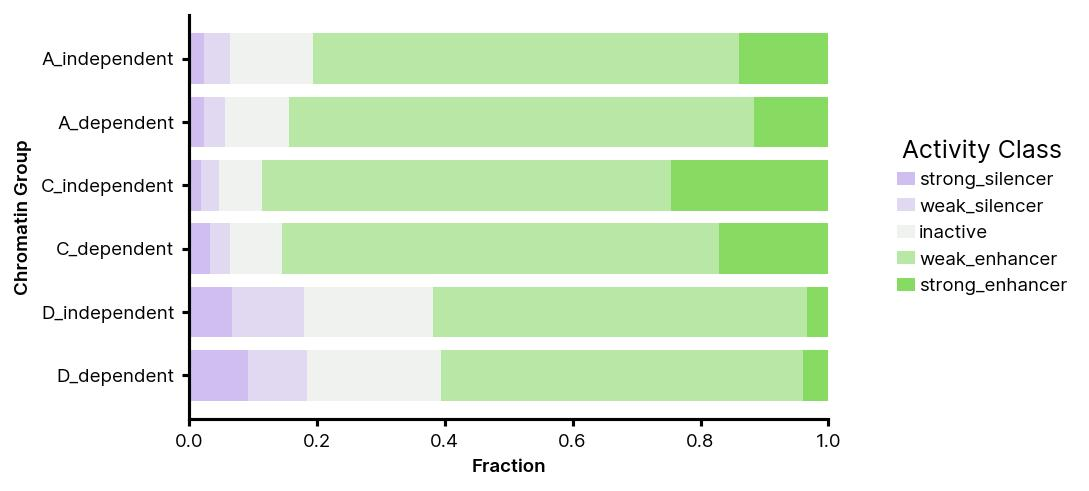

In [15]:
for library_name, library_df in processed_samples_counts.filter((polars.col("variant_type") == "wildtype") & (polars.col("genotype") == "WT")).sort("library").group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Fraction of Activity Classifications by chromatin annotation of CRE genomic origin in +/+"))
    
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
    
    data = library_df.with_columns([
        polars.col("activity_mean") + 2e-5,
        polars.when(polars.col("activity_class") == "strong_enhancer").then(4)
        .when(polars.col("activity_class") == "weak_enhancer").then(3)
        .when(polars.col("activity_class") == "inactive").then(2)
        .when(polars.col("activity_class") == "weak_silencer").then(1)
        .when(polars.col("activity_class") == "strong_silencer").then(0).alias("activity_class_rank")
    ]).sort(["epigenome_group", "atac_crx_dependent", "activity_class_rank"]).group_by(["epigenome_group", "atac_crx_dependent", "activity_class"], maintain_order=True).agg([
        polars.count().alias("num_CREs")
    ]).with_columns([
        polars.sum("num_CREs").over(["epigenome_group", "atac_crx_dependent"]).alias("total_CREs")
    ]).with_columns([
        (polars.col("num_CREs")/polars.col("total_CREs")).alias("fraction_CREs")
    ])
    
    x_axis_labels = []
    
    prior_row = None
    for (activity_class_name, group_data), color in zip(data.group_by("activity_class", maintain_order=True), seaborn.diverging_palette(280, 120, l=80, n=5, center="light")):
        if prior_row is None:
            axes.barh(y=group_data["epigenome_group"]+"_"+group_data["atac_crx_dependent"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", facecolor=color)
            prior_row = group_data["fraction_CREs"]
        else:
            axes.barh(y=group_data["epigenome_group"]+"_"+group_data["atac_crx_dependent"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", left=prior_row, facecolor=color)
            prior_row += group_data["fraction_CREs"]
    
    axes.set(xlim=(0, 1), xlabel="Fraction", ylabel="Chromatin Group")
    axes.legend(loc="right", title=f"Activity Class", facecolor="#ffffff", bbox_to_anchor=(1.4,0.5))
    axes.invert_yaxis()
    
    figure.savefig(f"Figures/fraction_activity_classes_by_epigenome_group_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

## [rho] Converted silencer epigenome group classifications

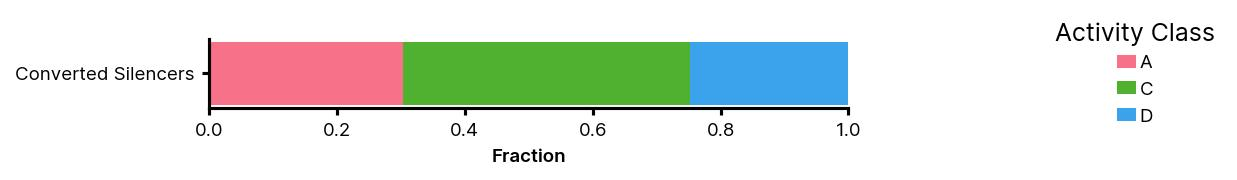

## [hsp68] Converted silencer epigenome group classifications

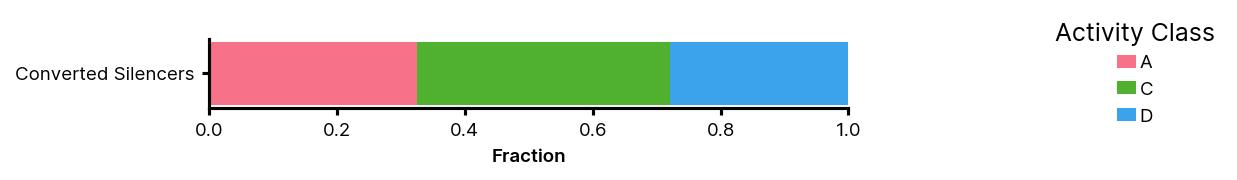

In [16]:
for library_name in ["rho", "hsp68"]:
    display(Markdown(f"## [{library_name}] Converted silencer epigenome group classifications"))
    
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5.5, 0.6))
    
    data = chip_peak_metadata.filter(
        polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_silencers_converted_in_e168d2"])
    ).sort(["epigenome_group"]).group_by(["epigenome_group"], maintain_order=True).agg([
        polars.count().alias("num_CREs")
    ]).with_columns([
        (polars.col("num_CREs")/polars.sum("num_CREs")).alias("fraction_CREs")
    ])
    
    x_axis_labels = []
    
    prior_row = None
    for (activity_class_name, group_data), color in zip(data.group_by("epigenome_group", maintain_order=True), seaborn.husl_palette(3)):
        if prior_row is None:
            axes.barh(y=["Converted Silencers"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", facecolor=color)
            prior_row = group_data["fraction_CREs"]
        else:
            axes.barh(y=["Converted Silencers"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", left=prior_row, facecolor=color)
            prior_row += group_data["fraction_CREs"]
    
    axes.set(xlim=(0, 1), ylabel=None, xlabel="Fraction")
    axes.legend(loc="right", title=f"Activity Class", facecolor="#ffffff", bbox_to_anchor=(1.6, 0.5))
    
    figure.savefig(f"Figures/fraction_activity_classes_converted_silencers_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

## [rho] CRX-dependent accessibility of CRE genomic origin (Group A)

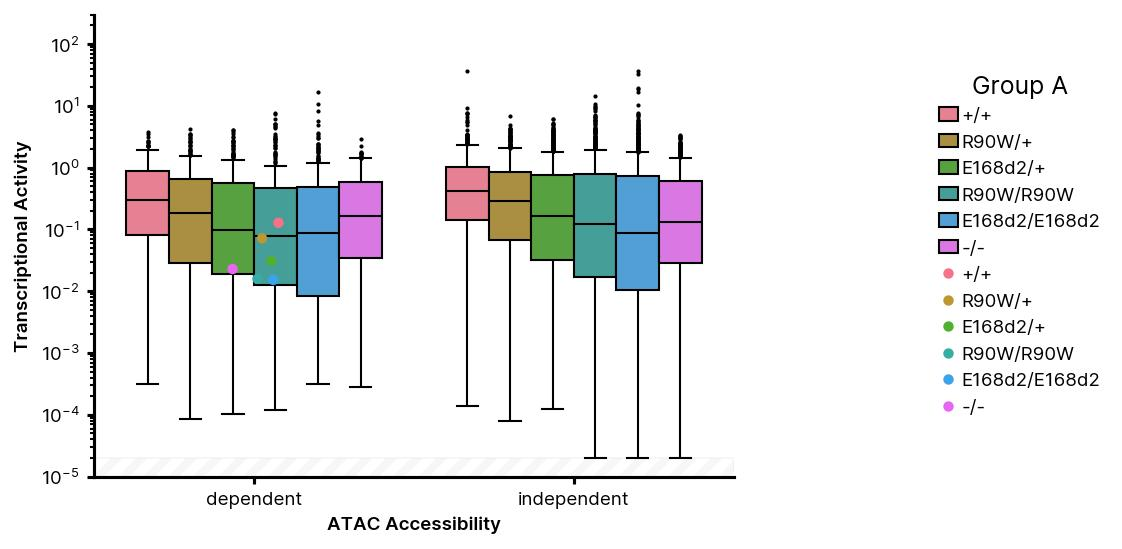

## [rho] CRX-dependent accessibility of CRE genomic origin (Group C)

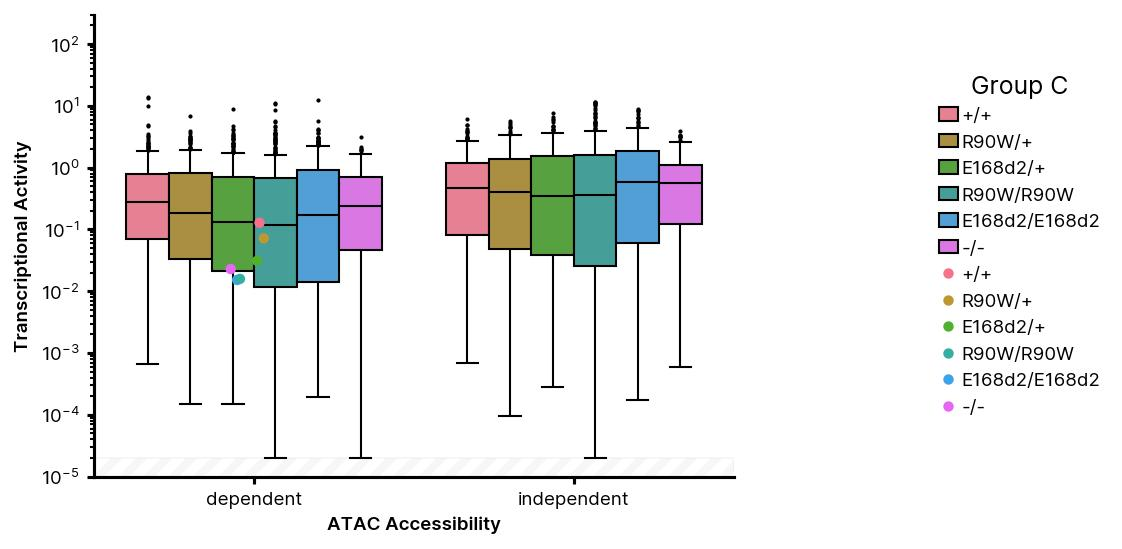

## [rho] CRX-dependent accessibility of CRE genomic origin (Group D)

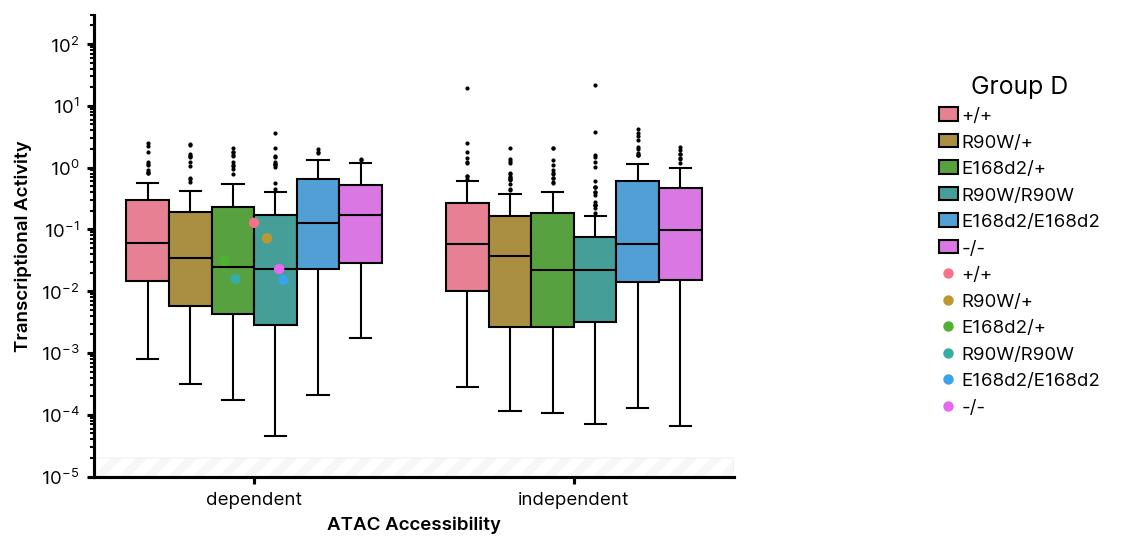

## [hsp68] CRX-dependent accessibility of CRE genomic origin (Group A)

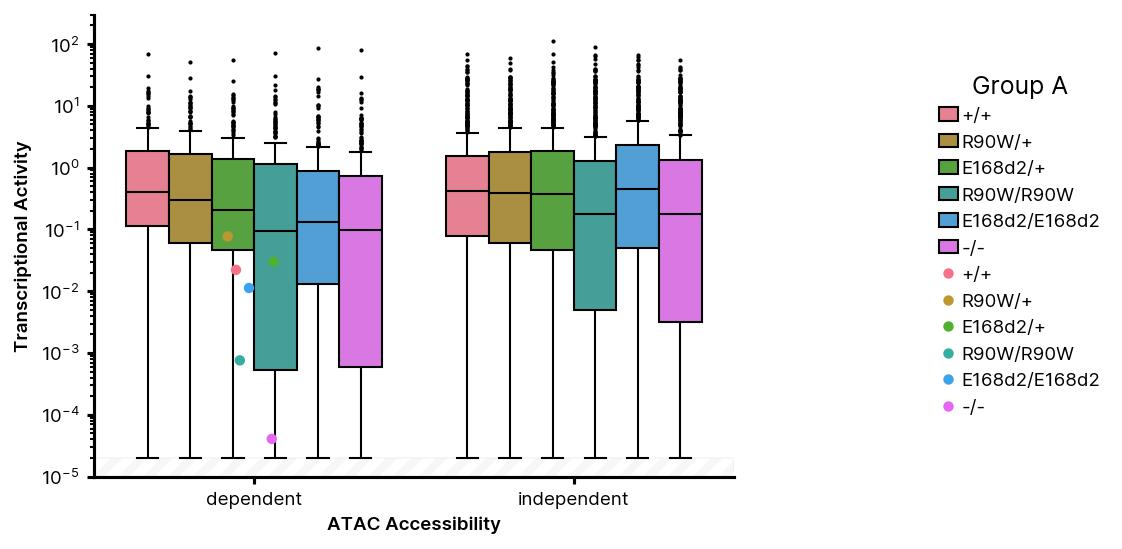

## [hsp68] CRX-dependent accessibility of CRE genomic origin (Group C)

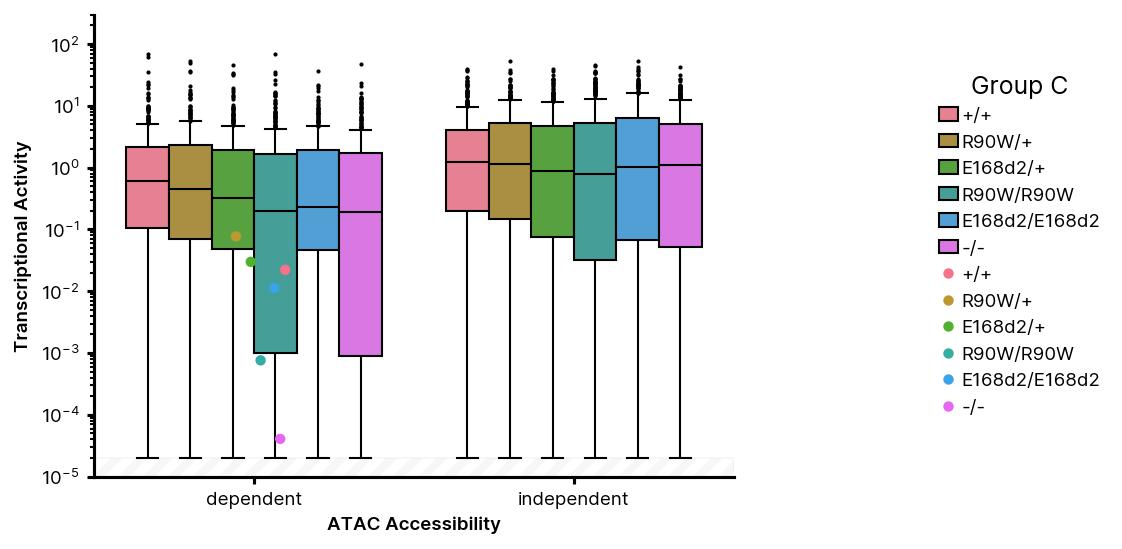

## [hsp68] CRX-dependent accessibility of CRE genomic origin (Group D)

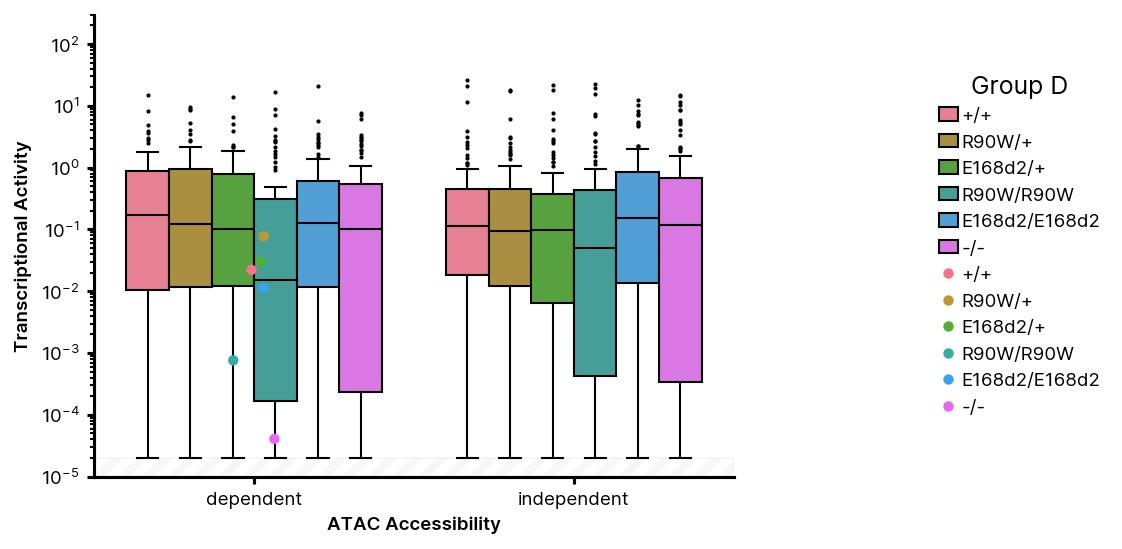

In [17]:
for (library_name, epigenome_group_name), library_df in processed_samples_counts.filter((polars.col("variant_type") == "wildtype")).sort(["library", "epigenome_group"]).group_by(["library", "epigenome_group"], maintain_order=True):
    display(Markdown(f"## [{library_name}] CRX-dependent accessibility of CRE genomic origin (Group {epigenome_group_name})"))
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5.5, 4))
    
    data = library_df.with_columns([
        polars.col("activity_mean") + 2e-5,
        polars.col("genotype").map_dict(NAME_TRANSLATION_TABLE),
    ]).to_pandas()
    
    basal_data = processed_samples_counts.filter(
        (polars.col("library_id") == "basal")
        & (polars.col("library") == library_name)
    ).with_columns([
        polars.col("activity_mean") + 2e-5
    ]).with_columns([
        polars.col("genotype").map_dict(NAME_TRANSLATION_TABLE)
    ]).select([
        "genotype",
        "activity_mean",
        polars.lit("dependent").alias("atac_crx_dependent")
    ]).to_pandas()
    
    plot_data_params = dict(
        data=data,
        x="atac_crx_dependent",
        y="activity_mean",
        hue="genotype",
        order=["dependent", "independent"],
        hue_order=["+/+", "R90W/+", "E168d2/+", "R90W/R90W", "E168d2/E168d2", "-/-"]
    )
    _ = seaborn.boxplot(ax=axes, **plot_data_params, notch=False, palette=seaborn.husl_palette(6), linewidth=1, dodge=True,  **boxplot_style_args)
    
    _ = seaborn.stripplot(ax=axes, data=basal_data, x=plot_data_params["x"], y=plot_data_params["y"], hue=plot_data_params["hue"], order=plot_data_params["order"], hue_order=plot_data_params["hue_order"], palette=seaborn.husl_palette(6), s=5, color="#ff7000")
    
    # Plot out-of-bounds
    axes.add_patch(matplotlib.patches.Polygon(
        xy=[(-0.5, 2e-5), (len(plot_data_params["order"]) - 0.5, 2e-5), (len(plot_data_params["order"]) - 0.5, 0), (0, 0)],
        facecolor="#00000000",
        edgecolor="#00000008",
        hatch=r"//"
    ))
    
    axes.set(ylim=(1e-5, 3e2), xlabel="ATAC Accessibility", ylabel="Transcriptional Activity")
    axes.set_yscale("log")
    axes.legend(loc="right", title=f"Group {epigenome_group_name}", facecolor="#ffffff", bbox_to_anchor=(1.6,0.5))
    
    figure.savefig(f"Figures/activity_by_atac_crx_dependence_group{epigenome_group_name}_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

---

# INFORMATION CONTENT ANALYSIS

---

In [18]:
information_content = polars.read_csv("Library_Details/library_information_content.tsv", separator="\t")
display(information_content)

library_id,predicted_occupancy_CRX,predicted_occupancy_GFI1,predicted_occupancy_MAZ,predicted_occupancy_MEF2D,predicted_occupancy_NDF1,predicted_occupancy_NRL,predicted_occupancy_RORB,predicted_occupancy_RAX,total_occupancy,diversity,info_content
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""basal""",1.507636,0.000007,8.3181e-7,1.2731e-10,3.0579e-12,0.022643,0.25191,0.011286,1.793483,1.0,0.488986
"""Scramble.1""",1.000677,1.5630e-7,1.014155,2.0923e-20,4.2304e-8,0.573843,4.6889e-8,1.9105e-10,2.588675,3.0,2.033248
"""Scramble.2""",0.426086,5.9586e-12,0.001926,2.4454e-13,0.08162,0.23204,0.001233,0.000001,0.742906,0.0,0.248695
"""Scramble.3""",2.166146,0.000024,3.1487e-8,3.6009e-8,2.253762,0.006329,0.173107,0.304233,4.903601,2.0,4.359958
"""Scramble.4""",1.131509,4.5440e-11,0.000656,1.1271e-12,0.000449,0.000206,4.2719e-7,0.000003,1.132824,1.0,0.002051
…,…,…,…,…,…,…,…,…,…,…,…
"""CRX.6340_full_…",0.439363,6.6716e-10,0.012425,1.5598e-11,6.9353e-10,0.891743,0.002822,0.003166,1.349519,1.0,0.516768
"""CRX.6342""",1.924086,2.3801e-7,0.006041,1.0088e-13,1.6163e-10,0.003213,0.064108,0.000285,1.997733,1.0,0.152932
"""CRX.6342_1_dou…",1.289053,2.3801e-7,0.006041,1.0088e-13,1.6163e-10,0.003212,0.064137,0.000285,1.362728,1.0,0.121817


## [rho] Subgroup information content and occupancy

### Predicted CRX Occupancy


```
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
```

- Converted Silencers (median=3.95) vs. Unconverted Silencers (median=3.19): Mann-Whitney U=3.83e+04 (pval=6.76e-09, ****)

- Converted Silencers (median=3.95) vs. Enhancers (median=2.72): Mann-Whitney U=1.83e+05 (pval=5.56e-34, ****)

- Enhancers (median=2.72) vs. Unconverted Silencers (median=3.19): Mann-Whitney U=1.07e+05 (pval=1.14e-05, ****)

### Information Content


```
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
```

- Converted Silencers (median=2.05) vs. Unconverted Silencers (median=1.32): Mann-Whitney U=3.57e+04 (pval=3.93e-05, ****)

- Converted Silencers (median=2.05) vs. Enhancers (median=1.80): Mann-Whitney U=1.28e+05 (pval=1.59e-01, ns)

- Enhancers (median=1.80) vs. Unconverted Silencers (median=1.32): Mann-Whitney U=1.50e+05 (pval=1.54e-04, ***)

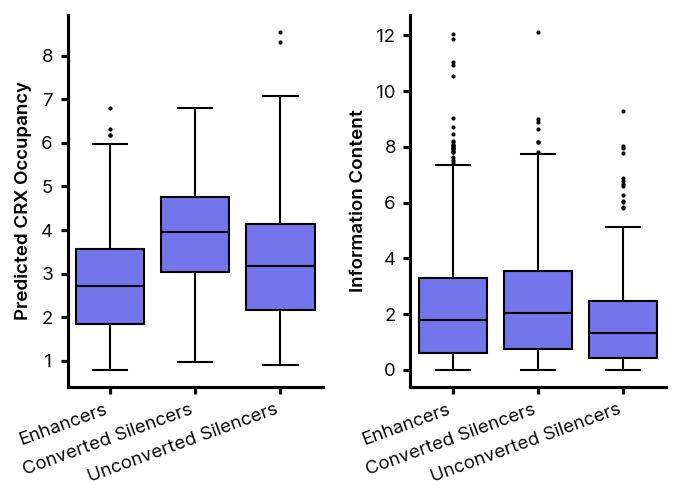

## [hsp68] Subgroup information content and occupancy

### Predicted CRX Occupancy


```
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
```

- Converted Silencers (median=3.13) vs. Unconverted Silencers (median=3.24): Mann-Whitney U=1.69e+03 (pval=9.46e-01, ns)

- Converted Silencers (median=3.13) vs. Enhancers (median=2.97): Mann-Whitney U=3.30e+04 (pval=3.27e-01, ns)

- Enhancers (median=2.97) vs. Unconverted Silencers (median=3.24): Mann-Whitney U=4.98e+04 (pval=1.60e-01, ns)

### Information Content


```
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
```

- Converted Silencers (median=1.68) vs. Unconverted Silencers (median=1.51): Mann-Whitney U=1.76e+03 (pval=6.59e-01, ns)

- Converted Silencers (median=1.68) vs. Enhancers (median=1.76): Mann-Whitney U=2.84e+04 (pval=4.71e-01, ns)

- Enhancers (median=1.76) vs. Unconverted Silencers (median=1.51): Mann-Whitney U=6.11e+04 (pval=9.98e-02, ns)

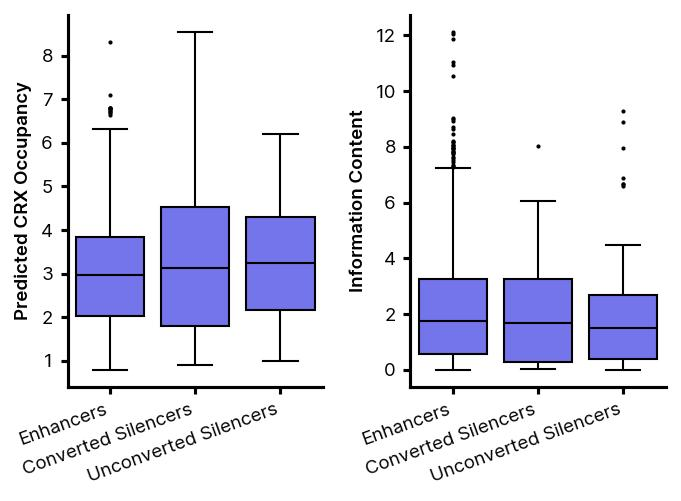

In [19]:
for library_name in ["rho", "hsp68"]:
    display(Markdown(f"## [{library_name}] Subgroup information content and occupancy"))
    
    data = library_metadata.filter(polars.col("variant_type") == "wildtype").with_columns([
        polars.when(polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_silencers_converted_in_e168d2"])).then(polars.lit("Converted Silencers"))
        .when(polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_enhancers"])).then(polars.lit("Enhancers"))
        .when(polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_silencers_not_converted_in_e168d2"])).then(polars.lit("Unconverted Silencers"))
        .otherwise(None).alias("derepression_status")
    ]).drop_nulls("derepression_status").join(information_content, on="library_id", how="left").sort("derepression_status")
    
    subplot_details = [
        ("predicted_occupancy_CRX", "Predicted CRX Occupancy"),
        ("info_content", "Information Content"),
    ]
    
    figure, axes = pyplot.subplots(nrows=1, ncols=len(subplot_details), figsize=(2.35*len(subplot_details), 3.5))
    
    for (yvar, ylabel), axis in zip(subplot_details, axes.flat):
        plot_data_params = dict(
            data=data.to_pandas(),
            x="derepression_status",
            y=yvar,
            order=["Enhancers", "Converted Silencers", "Unconverted Silencers"],
        )
        _ = seaborn.boxplot(ax=axis, **plot_data_params, notch=False, color="#6060ff", linewidth=1, **boxplot_style_args)

        axis.set(xlabel=None, ylabel=ylabel)
        axis.tick_params(axis="x", rotation=20)
        for label in axis.get_xticklabels():
            label.set_ha("right")
        axis.legend([],[], frameon=False)
    
        display(Markdown(f"### {ylabel}"))
        display(Markdown("""
```
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04
```"""))
        def compute_asterisk(pval):
            if pval <= 1e-4:
                return "****"
            elif pval <= 1e-3:
                return "***"
            elif pval <= 1e-2:
                return "**"
            elif pval <= 5e-2:
                return "*"
            else:
                return "ns"

        
        for first_group, second_group in (
            ("Converted Silencers", "Unconverted Silencers"),
            ("Converted Silencers", "Enhancers"),
            ("Enhancers", "Unconverted Silencers"),
        ):
            first_data = data.filter(polars.col("derepression_status") == first_group)[yvar]
            second_data = data.filter(polars.col("derepression_status") == second_group)[yvar]
            ustat, pval = scipy.stats.mannwhitneyu(first_data, second_data, alternative="two-sided", nan_policy="raise")
            display(Markdown(f"- {first_group} (median={first_data.median():0.2f}) vs. {second_group} (median={second_data.median():0.2f}): Mann-Whitney U={ustat:0.2e} (pval={pval:0.2e}, {compute_asterisk(pval)})"))

    figure.tight_layout()
    figure.savefig(f"Figures/information_content_and_occupancy_E168d2_converted_silencers_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

In [20]:
import statsmodels

bcor_overlap = polars.read_csv("BCOR/CRX_BCOR_overlap.tsv", separator="\t").with_columns([
    ((polars.col("nearby_BCOR_in_P0") > 0)).alias("overlaps_BCOR")
])

display(Markdown("## CRX ChIP Peak Overlap with BCOR Cut&Run"))
display(bcor_overlap)

# column value is the number of replicates (0, 1, or 2) in which a BCOR peak overlapped the given CRX ChIP peak

comparisons = [
    ("wt_silencers_converted_in_e168d2", "wt_silencers"),
]

for library_name in ["rho", "hsp68"]:
    display(Markdown(f"### {library_name}"))
    
    for subgroup1, subgroup2 in comparisons:
        display(Markdown(f"#### {subgroup1} vs. {subgroup2}"))
        
        num_elems_1 = len(element_subgroups[library_name][subgroup1])
        num_bcor_overlapping_1 = bcor_overlap.filter(polars.col("chip_peak_id").is_in(element_subgroups[library_name][subgroup1]) & polars.col("overlaps_BCOR")).height
            
        num_elems_2 = len(element_subgroups[library_name][subgroup2])
        num_bcor_overlapping_2 = bcor_overlap.filter(polars.col("chip_peak_id").is_in(element_subgroups[library_name][subgroup2]) & polars.col("overlaps_BCOR")).height

        print(f"{num_bcor_overlapping_1}/{num_elems_1} ({num_bcor_overlapping_1/num_elems_1:0.2%}) vs. {num_bcor_overlapping_2}/{num_elems_2} ({num_bcor_overlapping_2/num_elems_2:0.2%})")
        
        zstat, pval = statsmodels.stats.proportion.proportions_ztest([num_bcor_overlapping_1, num_bcor_overlapping_2], [num_elems_1, num_elems_2])
        
        print(f"z={zstat:.2e}, p={pval:.2e}")

## CRX ChIP Peak Overlap with BCOR Cut&Run

chip_peak_id,nearby_BCOR_in_adult,nearby_BCOR_in_P0,overlaps_BCOR
str,i64,i64,bool
"""CRX.3""",0,0,false
"""CRX.4""",0,2,true
"""CRX.6""",0,0,false
"""CRX.8""",0,0,false
"""CRX.12""",0,0,false
…,…,…,…
"""CRX.6320""",1,0,false
"""CRX.6321""",0,0,false
"""CRX.6329""",0,0,false


### rho

#### wt_silencers_converted_in_e168d2 vs. wt_silencers

11/234 (4.70%) vs. 57/485 (11.75%)
z=-3.03e+00, p=2.47e-03


### hsp68

#### wt_silencers_converted_in_e168d2 vs. wt_silencers

5/43 (11.63%) vs. 18/121 (14.88%)
z=-5.27e-01, p=5.98e-01


---

# NEARBY GENES TO CRES

---

In [21]:
"""
Read in list of nearby transcriptional start sites
"""

cre_nearest_gene = polars.read_csv("Library_Details/library_nearby_tss.tsv", separator="\t").with_columns([
    polars.when(polars.col("nearby_gene_tss") >= polars.col("chip_peak_stop")).then(polars.col("nearby_gene_tss") - polars.col("chip_peak_stop"))
        .when(polars.col("nearby_gene_tss") <= polars.col("chip_peak_start")).then(polars.col("chip_peak_start") - polars.col("nearby_gene_tss"))
        .otherwise(0).alias("nearby_gene_tss_distance")
]).group_by(["chip_peak_id"], maintain_order=True).agg([
    polars.all().sort_by("nearby_gene_tss_distance").first()
])

display(Markdown("## Nearest gene to each CRE"))
display(cre_nearest_gene)

## Nearest gene to each CRE

chip_peak_id,chip_peak_start,chip_peak_stop,nearby_ensembl_gene_id,nearby_gene_name,nearby_gene_tss,nearby_gene_tss_distance
str,i64,i64,str,str,i64,i64
"""CRX.3""",4453976,4454140,"""ENSMUSG0000002…","""Rp1""",4430537,23439
"""CRX.4""",4927867,4928031,"""ENSMUSG0000003…","""Tcea1""",4928261,230
"""CRX.6""",5140485,5140649,"""ENSMUSG0000000…","""Rgs20""",5140508,0
"""CRX.8""",10079329,10079493,"""ENSMUSG0000002…","""Ppp1r42""",10079361,0
"""CRX.12""",13730773,13730937,"""ENSMUSG0000002…","""Lactb2""",13730770,3
…,…,…,…,…,…,…
"""CRX.6320""",133102228,133102392,"""ENSMUSG0000005…","""Arl13a""",133088250,13978
"""CRX.6321""",133197619,133197783,"""ENSMUSG0000003…","""Tmem35a""",133195974,1645
"""CRX.6329""",151029910,151030074,"""ENSMUSG0000002…","""Kdm5c""",151016016,13894


In [22]:
cre_nearest_gene.write_csv("CRE_nearest_gene.tsv", separator="\t")

### [rho] TSS Distance for subgroups

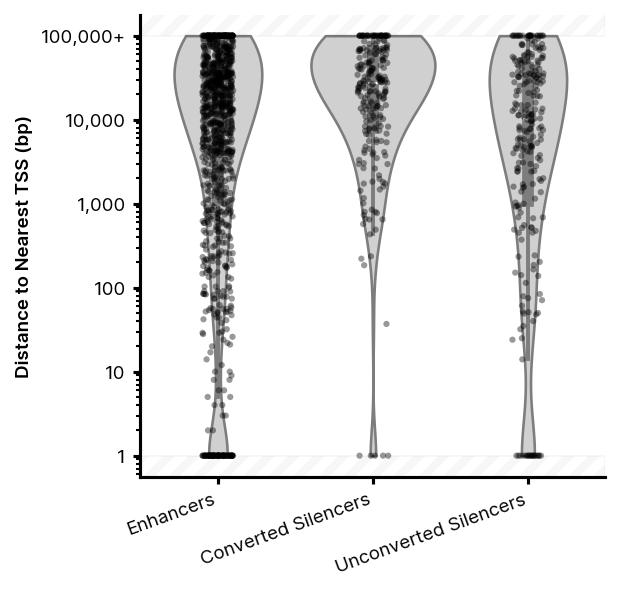

### [hsp68] TSS Distance for subgroups

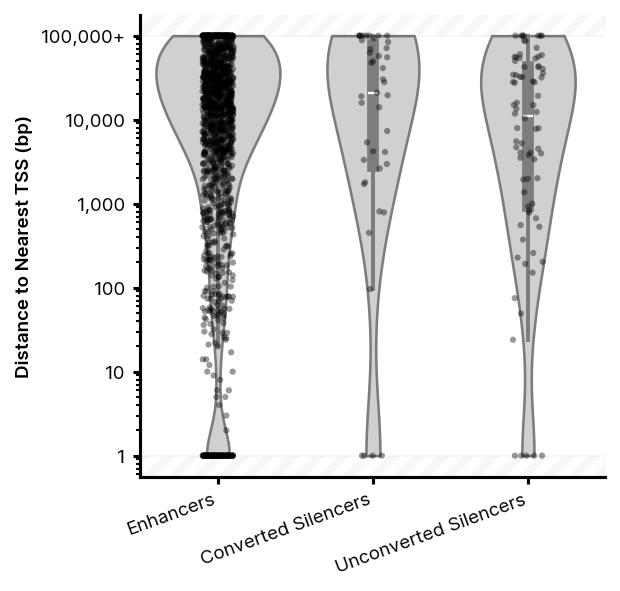

In [23]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    nearby_gene_df = library_df.filter(
        (polars.col("genotype") == "WT") &
        (polars.col("variant_type") == "wildtype")
    ).join(cre_nearest_gene, how="left", on="chip_peak_id").with_columns([
        polars.when(
            polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_silencers_converted_in_e168d2"])
        ).then(polars.lit("Converted Silencers")).when(
            polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_enhancers"])
        ).then(polars.lit("Enhancers")).when(
            polars.col("chip_peak_id").is_in(element_subgroups[library_name]["wt_silencers_not_converted_in_e168d2"])
        ).then(polars.lit("Unconverted Silencers")).otherwise(None).alias("CRE_class")
    ]).filter(polars.col("CRE_class").is_null().not_()).with_columns([
        polars.col("nearby_gene_tss_distance").fill_null(1e5) + 1
    ])
    
    figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(4, 4))

    plot_data_params = {
        "ax": axis,
        "data": nearby_gene_df.to_pandas(),
        "x": "CRE_class",
        "y": "nearby_gene_tss_distance",
        "log_scale": True,
        "order": ["Enhancers", "Converted Silencers", "Unconverted Silencers"]
    }
    
    seaborn.stripplot(**plot_data_params, s=3, alpha=0.4, edgecolor="none", rasterized=True)
    seaborn.violinplot(**plot_data_params, color="#d0d0d0", cut=0)

    axis.set(xlabel=None, ylabel="Distance to Nearest TSS (bp)")
    axis.tick_params(axis="x", rotation=20)
    
    axis.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5], labels=["1", "10", "100", "1,000", "10,000", "100,000+"])

    # Plot out-of-bounds
    axis.add_patch(matplotlib.patches.Polygon(
        xy=[(-0.5, 1), (2.5, 1), (2.5, 0.1), (-0.5, 0.1)],
        facecolor="#00000000",
        edgecolor="#00000008",
        hatch=r"//"
    ))
    axis.add_patch(matplotlib.patches.Polygon(
        xy=[(-0.5, 1e5), (2.5, 1e5), (2.5, 1e6), (-0.5, 1e6)],
        facecolor="#00000000",
        edgecolor="#00000008",
        hatch=r"//"
    ))
    
    for label in axis.get_xticklabels():
        label.set_ha("right")
    axis.legend([],[], frameon=False)
    
    display(Markdown(f"### [{library_name}] TSS Distance for subgroups"))
    figure.savefig(f"Figures/nearest_tss_distance_by_subgroup_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)

In [24]:
photoreceptor_enriched_genes = polars.read_csv("Library_Details/photoreceptor_enriched_genes.tsv", separator="\t")
display(photoreceptor_enriched_genes)

photoreceptor_gene_cres = photoreceptor_enriched_genes.join(cre_nearest_gene, how="left", left_on="gene_name", right_on="nearby_gene_name").select([
    polars.col("chip_peak_id"),
    polars.col("gene_name"),
    polars.col("enrichment").alias("cell_type_enrichment")
])
display(photoreceptor_gene_cres)

gene_name,enrichment
str,str
"""Hspa1b""","""rod"""
"""Susd3""","""rod"""
"""Samd7""","""rod"""
"""Pdc""","""rod"""
"""Ric8b""","""rod"""
…,…
"""Tmsb10""","""cone"""
"""Slc17a3""","""rod"""
"""Ramp3""","""rod"""


chip_peak_id,gene_name,cell_type_enrichment
str,str,str
"""CRX.2566""","""Hspa1b""","""rod"""
"""CRX.2567""","""Hspa1b""","""rod"""
"""CRX.1605""","""Susd3""","""rod"""
"""CRX.3721""","""Samd7""","""rod"""
"""CRX.3722""","""Samd7""","""rod"""
…,…,…
"""CRX.4879""","""Tmsb10""","""cone"""
"""CRX.1531""","""Slc17a3""","""rod"""
"""CRX.726""","""Ramp3""","""rod"""


## [rho] Heatmap of CRE activity across all genotypes of CREs near photoreceptor genes

,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,
CRX.3178(Nhlrc2),0.051063,1.344674,2.040898,1087.295225,696.194380
CRX.2198(Parvg),0.043343,0.386250,0.089770,1757.861055,261.071683
CRX.6224(Ip6k2),1.696803,5.031519,9.643923,37.086814,64.097448
CRX.516(Pcdh15),2.264744,17.167568,23.932576,59.665928,61.718026
CRX.4237(Ece1),1.985198,3.618565,8.684677,29.129880,36.023905
...,...,...,...,...,...
CRX.3369(Rtn4rl2),1.504598,0.146804,0.463206,0.037058,0.107913
CRX.5359(Cckbr),0.420060,0.077925,0.043596,0.003226,0.097150
CRX.3243(Olfm1),0.079687,0.043847,0.020211,0.025564,0.061891


### cone

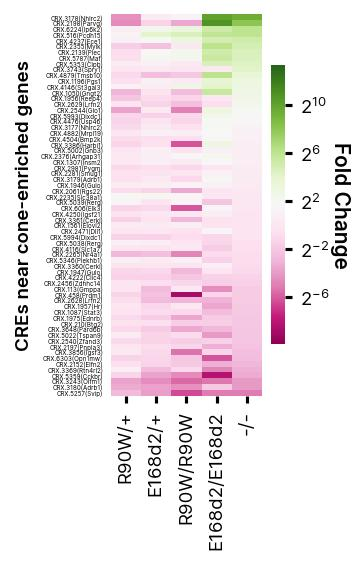

,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,
CRX.594(Ric8b),0.037745,2.219037,13.166994,783.458424,122.944422
CRX.1350(Syne2),0.048988,1.182313,0.689334,59.192823,29.845214
CRX.4830(Ccdc126),0.419428,0.546705,0.880180,11.068664,12.892086
CRX.2721(Epas1),1.082301,0.190514,2.162280,0.263328,10.360501
CRX.5510(Ap2a2),0.572976,0.853877,0.478419,10.689518,4.877741
...,...,...,...,...,...
CRX.707(Sec14l2),0.018504,0.026300,0.004372,0.101071,0.036202
CRX.1406(Esrrb),0.124527,0.009447,0.353754,0.004735,0.029787
CRX.3981(B4galt1),0.090147,0.045363,0.017669,2.527470,0.024253


### rod

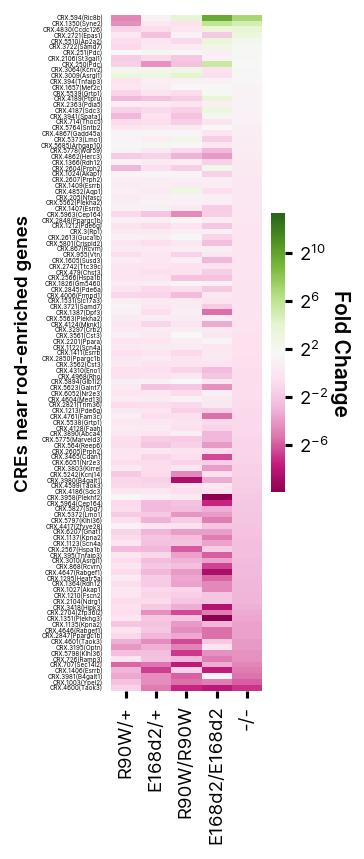

## [hsp68] Heatmap of CRE activity across all genotypes of CREs near photoreceptor genes

,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,
CRX.3743(Spry1),44.001955,0.000000,3280.432439,374.754990,4162.467322
CRX.2198(Parvg),0.796078,5.859142,52.225294,425.963552,414.351695
CRX.2628(Lrfn2),26.044485,0.591194,10.379210,13.674716,14.781207
CRX.2139(Plec),0.138376,0.519796,4.317476,12.755548,13.883178
CRX.5353(Clpb),1.932101,1.980981,0.037373,3.264586,10.978068
...,...,...,...,...,...
CRX.4222(Clic4),0.475262,0.167568,0.003396,0.175562,0.000888
CRX.5993(Dixdc1),0.642963,1.469176,0.306993,6.797473,0.000877
CRX.2265(Nr4a1),0.071504,0.080993,0.165446,0.000457,0.000229


### cone

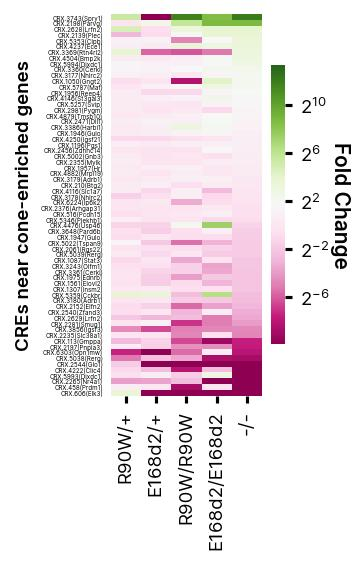

,R90W/+,E168d2/+,R90W/R90W,E168d2/E168d2,-/-
CRE,,,,,
CRX.3981(B4galt1),NaN,NaN,inf,inf,inf
CRX.594(Ric8b),2.474598,5.780222,26.326782,145.198143,44.483960
CRX.250(Pdc),0.277138,1.026954,1.838275,4.835478,21.832555
CRX.5798(Klhl36),2.824772,3.196076,0.064792,4.705567,18.487999
CRX.2721(Epas1),8.206763,1.835355,4.011922,1.712972,11.002191
...,...,...,...,...,...
CRX.5623(Galnt7),1.061304,0.119293,0.000000,4.981068,0.000000
CRX.707(Sec14l2),0.908905,0.043418,0.037504,0.032599,0.000000
CRX.3418(Hipk3),0.233955,0.206084,0.000000,0.469841,0.000000


### rod

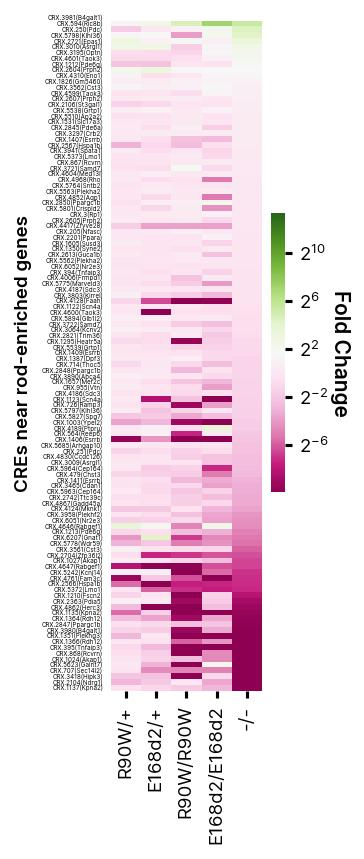

In [25]:
for library_name, library_df in processed_samples_counts.sort(["library"]).group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Heatmap of CRE activity across all genotypes of CREs near photoreceptor genes"))
    
    for enriched_cell_type, df in photoreceptor_gene_cres.join(library_df.filter(polars.col("variant_type") == "wildtype"), how="left", on="chip_peak_id").sort(["cell_type_enrichment"]).group_by("cell_type_enrichment", maintain_order=True):
        
        tmp_name_table = NAME_TRANSLATION_TABLE.copy()
        tmp_name_table.pop("WT")
        tmp_name_table.pop("chip_peak_id")
        tmp_name_table["joint_id"] = "CRE"
        
        heatmap_data = df.join(
            df.filter(polars.col("genotype") == "WT").select([
                polars.col("library_id"),
                polars.col("activity_mean").alias("activity_mean_wt")
            ]), how="left", on="library_id"
        ).with_columns([
            (polars.col("activity_mean")/polars.col("activity_mean_wt")).alias("fold_change"),
            polars.concat_str([polars.col("chip_peak_id"), polars.lit("("), polars.col("gene_name"), polars.lit(")")]).alias("joint_id")
        ]).pivot(values="fold_change", index="joint_id", columns="genotype").select([
            "joint_id",
            "Rhet",
            "Ehet",
            "Rhom",
            "Ehom",
            "CrxKO"
        ]).sort(polars.col("CrxKO"), descending=True).rename(tmp_name_table)
        

        activity_df = heatmap_data.to_pandas().set_index("CRE")
        display(activity_df)

        figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(1.5, 5 * (len(heatmap_data)/100)))

        cmap = pyplot.get_cmap("PiYG")
        cmap.set_over("#0000ff")
        cmap.set_under("#000000")
        
        axes = seaborn.heatmap(axes=axes, data=activity_df, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1e4, clip=True), yticklabels=True, rasterized=True, cbar_kws={"fraction": 0.08})
        axes.tick_params(axis="y", labelsize=3, width=0, pad=0)
        axes.set(ylabel=f"CREs near {enriched_cell_type}-enriched genes")
        axes.collections[0].colorbar.ax.set_ylabel("Fold Change", rotation=270, labelpad=10, fontsize=10)
        axes.collections[0].colorbar.ax.set_yscale("log", base=2)
        display(Markdown(f"### {enriched_cell_type}"))
        figure.savefig(f"Figures/{enriched_cell_type}-enriched_element_activity_heatmap_across_genotypes_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
        display(figure)
        pyplot.close(figure)

## [rho] Fraction of Activity Classifications by enriched gene

cell_type_enrichment,activity_class,num_CREs,total_CREs,fraction_CREs
str,cat,u32,u32,f64
"""cone""","""strong_silence…",11,66,0.166667
"""cone""","""weak_silencer""",14,66,0.212121
"""cone""","""inactive""",4,66,0.060606
"""cone""","""weak_enhancer""",30,66,0.454545
"""cone""","""strong_enhance…",7,66,0.106061
"""rod""","""strong_silence…",1,117,0.008547
"""rod""","""weak_silencer""",15,117,0.128205
"""rod""","""inactive""",15,117,0.128205
"""rod""","""weak_enhancer""",61,117,0.521368


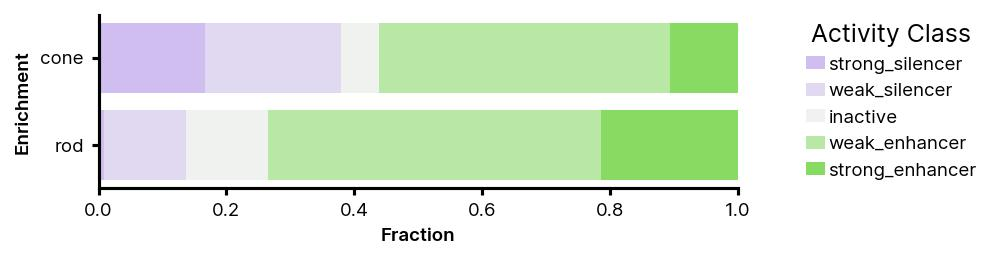

## [hsp68] Fraction of Activity Classifications by enriched gene

cell_type_enrichment,activity_class,num_CREs,total_CREs,fraction_CREs
str,cat,u32,u32,f64
"""cone""","""strong_silence…",3,66,0.045455
"""cone""","""weak_silencer""",4,66,0.060606
"""cone""","""inactive""",5,66,0.075758
"""cone""","""weak_enhancer""",44,66,0.666667
"""cone""","""strong_enhance…",10,66,0.151515
"""rod""","""weak_silencer""",2,117,0.017094
"""rod""","""inactive""",12,117,0.102564
"""rod""","""weak_enhancer""",74,117,0.632479
"""rod""","""strong_enhance…",29,117,0.247863


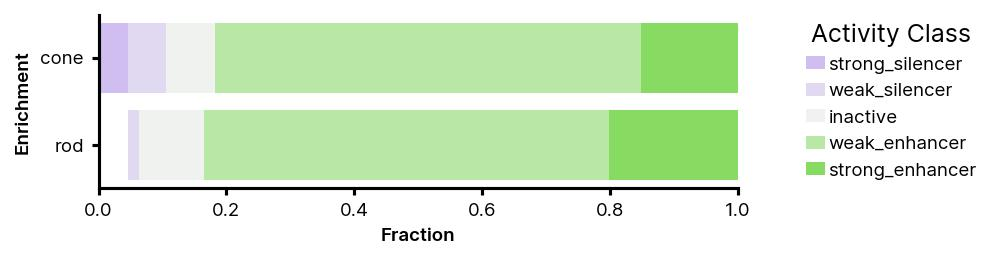

In [26]:
for library_name, library_df in processed_samples_counts.filter((polars.col("variant_type") == "wildtype") & (polars.col("genotype") == "WT")).sort("library").group_by("library", maintain_order=True):
    display(Markdown(f"## [{library_name}] Fraction of Activity Classifications by enriched gene"))
    
    figure, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5.5, 1.5))
    
    data = photoreceptor_gene_cres.join(library_df, how="left", on="chip_peak_id").sort(["cell_type_enrichment"]).with_columns([
        polars.col("activity_mean") + 2e-5,
        polars.when(polars.col("activity_class") == "strong_enhancer").then(4)
        .when(polars.col("activity_class") == "weak_enhancer").then(3)
        .when(polars.col("activity_class") == "inactive").then(2)
        .when(polars.col("activity_class") == "weak_silencer").then(1)
        .when(polars.col("activity_class") == "strong_silencer").then(0).alias("activity_class_rank")
    ]).sort(["genotype", "cell_type_enrichment", "activity_class_rank"]).group_by(["cell_type_enrichment", "activity_class"], maintain_order=True).agg([
        polars.count().alias("num_CREs")
    ]).with_columns([
        polars.sum("num_CREs").over(["cell_type_enrichment"]).alias("total_CREs")
    ]).with_columns([
        (polars.col("num_CREs")/polars.col("total_CREs")).alias("fraction_CREs")
    ])
    display(data)
    
    x_axis_labels = []
    
    prior_row = None
    for (activity_class_name, group_data), color in zip(data.group_by("activity_class", maintain_order=True), seaborn.diverging_palette(280, 120, l=80, n=5, center="light")):
        if prior_row is None:
            axes.barh(y=group_data["cell_type_enrichment"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", facecolor=color)
            prior_row = group_data["fraction_CREs"]
        else:
            axes.barh(y=group_data["cell_type_enrichment"], width=group_data["fraction_CREs"], label=f"{activity_class_name}", left=prior_row, facecolor=color)
            prior_row += group_data["fraction_CREs"]
    
    axes.set(xlim=(0, 1), xlabel="Fraction", ylabel="Enrichment")
    axes.legend(loc="right", title=f"Activity Class", facecolor="#ffffff", bbox_to_anchor=(1.4,0.5))
    axes.invert_yaxis()
    
    figure.savefig(f"Figures/fraction_activity_classes_by_cell_type_enriched_genes_{library_name}.{FIGURE_EXPORT_TYPE}", bbox_inches="tight")
    display(figure)
    pyplot.close(figure)